<div class="alert alert-info">
<font size="3"><b>Комментарий студента v0</b></font>

Привет! Впервые за весь курс обучения напишу сразу при сдаче проекта:

Проект сырой и положительный результат работы не достигнут. 

Мне нужна помощь, чтобы разобраться не только в том, почему получен плохой результат, но и в целом в структуре проекта

# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

### Импорты и загрузка данных и их первичный анализ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import textwrap
import spacy
from PIL import Image
from IPython.display import display
from tqdm import notebook 
from os.path import exists, isfile, join


# import helper
import torch
import torch.nn as nn
import transformers 
from transformers import BertTokenizer, BertModel
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models

# отдельно пропишу путь к папке с файлами и зафиксирую random_seed
path = r'C:\Users\Alexander\practicum\practicum_env\Сборный проект 5\to_upload'
rnd_seed=12345
from sklearn.metrics import r2_score
from torch.autograd import Variable
from torch.nn import Linear, Module, MSELoss
from torch.optim import SGD
import torch.optim as optim


Вычисления на torch попробовал делать на GPU локально

In [2]:
print("PyTorch version:", torch.__version__)
print("Is CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Версия cuDNN:", torch.backends.cudnn.version())

PyTorch version: 2.4.1+cu124
Is CUDA available: True
CUDA version: 12.4
Версия cuDNN: 90100


In [3]:
# у меня ломалось ядро по всей видимости из-за конфликта библиотек при запуске matplotlib.pyplot, такое решение помогло
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

Загрузим файлы, которые есть в папке

#### train_data

In [4]:
train_data = pd.read_csv(os.path.join(path,'train_dataset.csv'))
train_data.head()


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [6]:
print('Длина тренировочного датасета:',len(train_data), 'строк')
print('Уникальных изображений в тренировочном датасете:', len(train_data['image'].unique()))
print('Уникальных идентификаторов описания изображений:', len(train_data['query_id'].unique()))
print('Уникальных текстов:', len(train_data['query_text'].unique()))
print('Явных дубликатов в таблице:', train_data.duplicated().sum())

Длина тренировочного датасета: 5822 строк
Уникальных изображений в тренировочном датасете: 1000
Уникальных идентификаторов описания изображений: 977
Уникальных текстов: 977
Явных дубликатов в таблице: 0


В тренировочном датасете всего 5822 строки, 1000 уникальных изображений и 977 уникальных текстовых запросов

In [7]:
train_data[train_data['image']=='1262583859_653f1469a9.jpg'].head()

image                     query_id  \
1    1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
85   1262583859_653f1469a9.jpg  2140182410_8e2a06fbda.jpg#2   
872  1262583859_653f1469a9.jpg  2218609886_892dcd6915.jpg#2   
878  1262583859_653f1469a9.jpg  2544182005_3aa1332bf9.jpg#2   
883  1262583859_653f1469a9.jpg   279728508_6bd7281f3c.jpg#2   

                                            query_text  
1    A young child is wearing blue goggles and sitt...  
85                 The kid is on a float in the snow .  
872  A man wearing a dark blue hat sits on the grou...  
878            A young child is riding a purple bike .  
883  A boys jumps in the water while another boy lo...

In [8]:
train_data[train_data['query_id']=='2549968784_39bfbe44f9.jpg#2'].head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [9]:
train_data['query_id'].unique()

array(['2549968784_39bfbe44f9.jpg#2', '2718495608_d8533e3ac5.jpg#2',
       '3181701312_70a379ab6e.jpg#2', '3207358897_bfa61fa3c6.jpg#2',
       '3286822339_5535af6b93.jpg#2', '3360930596_1e75164ce6.jpg#2',
       '3545652636_0746537307.jpg#2', '434792818_56375e203f.jpg#2',
       '1425069308_488e5fcf9d.jpg#2', '1714316707_8bbaa2a2ba.jpg#2',
       '2140182410_8e2a06fbda.jpg#2', '2398605966_1d0c9e6a20.jpg#2',
       '2479652566_8f9fac8af5.jpg#2', '3119076670_64b5340530.jpg#2',
       '317488612_70ac35493b.jpg#2', '493621130_152bdd4e91.jpg#2',
       '1287475186_2dee85f1a5.jpg#2', '1536774449_e16b1b6382.jpg#2',
       '2472980433_210ec62874.jpg#2', '2893374123_087f98d58a.jpg#2',
       '2358554995_54ed3baa83.jpg#2', '2544426580_317b1f1f73.jpg#2',
       '256085101_2c2617c5d0.jpg#2', '3385593926_d3e9c21170.jpg#2',
       '3396157719_6807d52a81.jpg#2', '542179694_e170e9e465.jpg#2',
       '191003285_edd8d0cf58.jpg#2', '2370481277_a3085614c9.jpg#2',
       '2577972703_a22c5f2a87.jpg#2', '3

Кроме того структура датасета такова, что к одному изображению может быть несколько запросов, но и по одному запросу может выдать несколько изображений

Кроме того порядковый номер описаний всех в столбце `query_id` - 2. Пока не совсем понятно с чем это связано.

**Но видно, что структура запроса - это имя фотографии и номер запроса, поэтому дальше проверим степень соответствия запросов к своим же фотографиям**

#### test_images

In [10]:
test_images = pd.read_csv(os.path.join(path,'test_images.csv'))
test_images.head()

image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

In [11]:
print('Длина тестового датасета:', len(test_images))
print('Уникальных изображений в тренировочном датасете:', len(test_images.image.unique()))

Длина тестового датасета: 100
Уникальных изображений в тренировочном датасете: 100


в файле test_images есть просто названия изображений из папки с изображениями. Их ровно 100 и все уникальные, вопросов тут нету

#### crowd annotations

In [12]:
crowd_ann = pd.read_csv(os.path.join(path,'CrowdAnnotations.tsv'), 
                        delimiter='\t', 
                        header=None, 
                        usecols=[0,1,2,3,4],
                        names=['image', 'query_id', 'similarity_rate', 'yes_num', 'no_num']
                       )
crowd_ann.head()

image                     query_id  similarity_rate  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2              1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2              0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2              0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2              0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2              0.0   

   yes_num  no_num  
0        3       0  
1        0       3  
2        0       3  
3        0       3  
4        0       3

In [13]:
crowd_ann.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            47830 non-null  object 
 1   query_id         47830 non-null  object 
 2   similarity_rate  47830 non-null  float64
 3   yes_num          47830 non-null  int64  
 4   no_num           47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [14]:
crowd_ann.duplicated().sum()

0

Посомтрим на количество уникальных сочетаний 

In [15]:
crowd_ann.groupby(['image', 'query_id']).count()

similarity_rate  \
image                     query_id                                       
1056338697_4f7d7ce270.jpg 1056338697_4f7d7ce270.jpg#2                1   
                          114051287_dd85625a04.jpg#2                 1   
                          1427391496_ea512cbe7f.jpg#2                1   
                          2073964624_52da3a0fc4.jpg#2                1   
                          2083434441_a93bc6306b.jpg#2                1   
...                                                                ...   
997722733_0cb5439472.jpg  543007912_23fc735b99.jpg#2                 1   
                          544576742_283b65fa0d.jpg#2                 1   
                          872622575_ba1d3632cc.jpg#2                 1   
                          888425986_e4b6c12324.jpg#2                 1   
                          997722733_0cb5439472.jpg#2                 1   

                                                       yes_num  no_num  
image                     query_id                                      
1056338697_4f7d7ce270.jpg 1056338697_4f7d7ce270.jpg#2        1       1  
                          114051287_dd85625a04.jpg#2         1       1  
                          1427391496_ea512cbe7f.jpg#2        1       1  
                          2073964624_52da3a0fc4.jpg#2        1       1  
                          2083434441_a93bc6306b.jpg#2        1       1  
...                                                        ...     ...  
997722733_0cb5439472.jpg  543007912_23fc735b99.jpg#2         1       1  
                          544576742_283b65fa0d.jpg#2         1       1  
                          872622575_ba1d3632cc.jpg#2         1       1  
                          888425986_e4b6c12324.jpg#2         1       1  
                          997722733_0cb5439472.jpg#2         1       1  

[47830 rows x 3 columns]

Дубликатов нет

In [16]:
print('Длина датасета:',len(crowd_ann))
print('Количество уникальных изображений:', len(crowd_ann['image'].unique()))
print('Количество уникальных идентификаторов описаний:', len(crowd_ann['query_id'].unique()))
print()


Длина датасета: 47830
Количество уникальных изображений: 1000
Количество уникальных идентификаторов описаний: 1000



In [17]:
round(crowd_ann.iloc[:, [2,3,4]].describe(),1)

similarity_rate  yes_num   no_num
count          47830.0  47830.0  47830.0
mean               0.1      0.2      2.8
std                0.2      0.6      0.7
min                0.0      0.0      0.0
25%                0.0      0.0      3.0
50%                0.0      0.0      3.0
75%                0.0      0.0      3.0
max                1.0      5.0      6.0

С помощью краудсорсинга была проверена степень соотвествия изображения и описания. Всего уникальных изображений 1000, уникальных описаний тоже 1000. Судя по тому, что уникальных сочетаний ровно столько, сколько строк в датасете - 47830, то получается что в среднем на проверяли сходство 1 изображения и 40-50 описаний к нему.

в оценке каждого сочетания изображение-описание участвовало не более 6 человек, посколькуо максимальное количество "не соответствует" по сочетаниям 6, а "соответствует" - 5. Можно конечно было и сумму посчитать, но думаю, что в этом смысла большого нет

Степень сходства лежит в нужном нам диапазоне [0,1]

#### expert annotations

In [18]:

expert_ann = pd.read_csv(os.path.join(path,'ExpertAnnotations.tsv'), 
                         delimiter='\t', 
                         header=None, 
                         usecols=[0,1,2,3,4],
                         names=['image', 'query_id', '1_exp', '2_exp', '3_exp']
                        )
expert_ann.head()

image                     query_id  1_exp  2_exp  3_exp
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1      1      1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1      1      2
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1      1      2
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1      2      2
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1      1      2

In [19]:
expert_ann.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   1_exp     5822 non-null   int64 
 3   2_exp     5822 non-null   int64 
 4   3_exp     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


In [20]:
print('Длина датасета:',len(expert_ann))
print('Количество уникальных изображений:', len(expert_ann['image'].unique()))
print('Количество уникальных идентификаторов описаний:', len(expert_ann['query_id'].unique()))

Длина датасета: 5822
Количество уникальных изображений: 1000
Количество уникальных идентификаторов описаний: 977


In [21]:
print('Количество дубликатов:', expert_ann.duplicated().sum())
print('Количество дубликатов в сочетаниях изображение-запрос:', expert_ann.loc[:, ['image', 'query_id']].duplicated().sum())

Количество дубликатов: 0
Количество дубликатов в сочетаниях изображение-запрос: 0


Эксперты размечали именно тренировочный датасет, что видно по длине таблицы, а также количеству уникальных значений изображений и запросов. То есть по сути это разметка тремя экспертами необходимого нам для обучения датасета.
 

#### Test queries

In [22]:
test_queries = pd.read_csv(os.path.join(path,'test_queries.csv'), 
                           delimiter='|',
                          index_col=0)
test_queries.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [23]:
test_queries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [24]:
print('Количество уникальных изображений в test_queries:', len(test_queries['image'].unique()))
print('Количество уникальных запросов в test_queries:', len(test_queries['query_id'].unique()))
print('Количество уникальных запросов в test_queries:', len(test_queries['query_text'].unique()))

Количество уникальных изображений в test_queries: 100
Количество уникальных запросов в test_queries: 500
Количество уникальных запросов в test_queries: 500


В датафрейме `test_queries` находится 100 изображений и 500 описаний к ним. В сущности задача сводится к тому, чтобы проверить как эти описания подходят к изображениям

#### Train images и test_images

.



**ВОПРОС**

у меня здесь вопрос, потому что я не знаю, как быть, нужен комментарий:

У нас две папки с фотографиями: `train_images` и `test_images`. В то же время, когдя я прописываю путь к папке, в которой лежат обе эти папки, то вижу, что распознается 1100 фотографий по 2 классам, а если путь прописываю конкретно к тренировочной, либо тестовой папке, то не вижу ничего. Но с этим я разобрался и суть вопроса не в этом. 

Чтобы мы видели только тренировочную, либо тестовую выборку, я создал "надпапку" `train`, чтобы путь выглядел так: `path + /train/train_images` и аналогично для тестовой, чтобы не было деления на классы и видело только отдельно одну из выборок. Правильно ли так делать? Или есть возможность как-то выбрать нужный датасет, прописав параметр в `ImageFolder` или загрузить каким-то иным образом фотографии?



Посмотрим на фотографии в тренировочной и тестовой выборках. Названия файлов я целенаправленно не выводил. т.к. в датасете к каждой фотографии существует несколько описаний

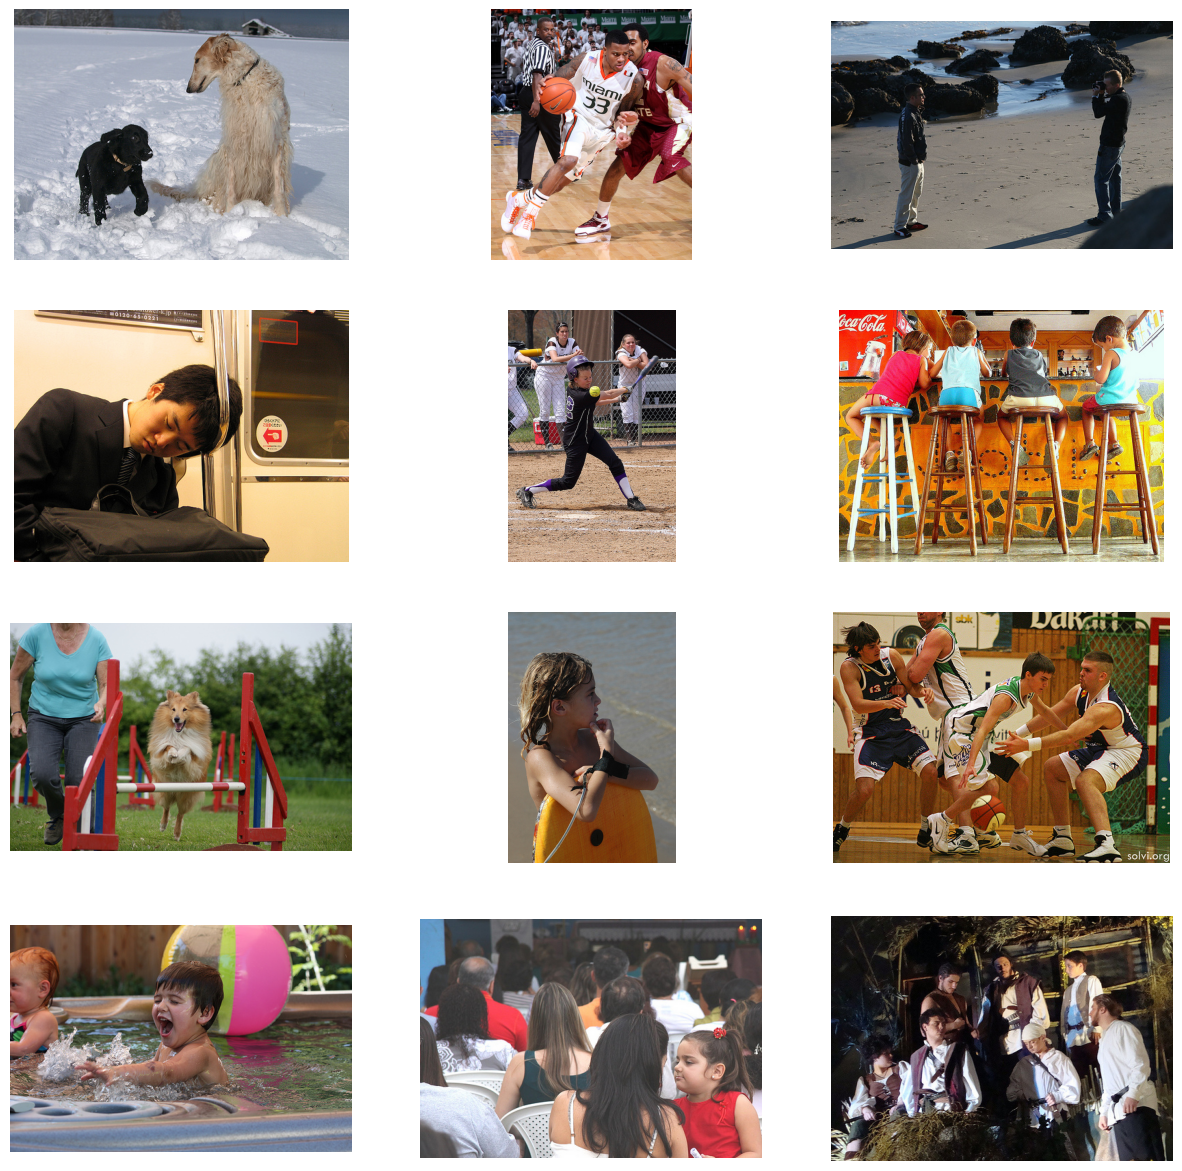

In [25]:
train_transforms = transforms.Compose([
                                # transforms.Resize(255),
                                # transforms.CenterCrop(256),
                                transforms.ToTensor()])

train_images = datasets.ImageFolder(root=os.path.join(path,'train'), 
                                    transform=train_transforms)


figure = plt.figure(figsize=(15, 15))
cols, rows = 3, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_images), size=(1,)).item()
    img, label = train_images[sample_idx]
    
    ax = figure.add_subplot(rows, cols, i)
    # wrapped_title = "\n".join(textwrap.wrap(train_data['query_text'][label], width=30))  
    # ax.set_title(wrapped_title) 
    ax.axis("off")
    
    img = img.permute(1, 2, 0)
    plt.imshow(img.squeeze())
plt.show()

Теперь тестовая выборка

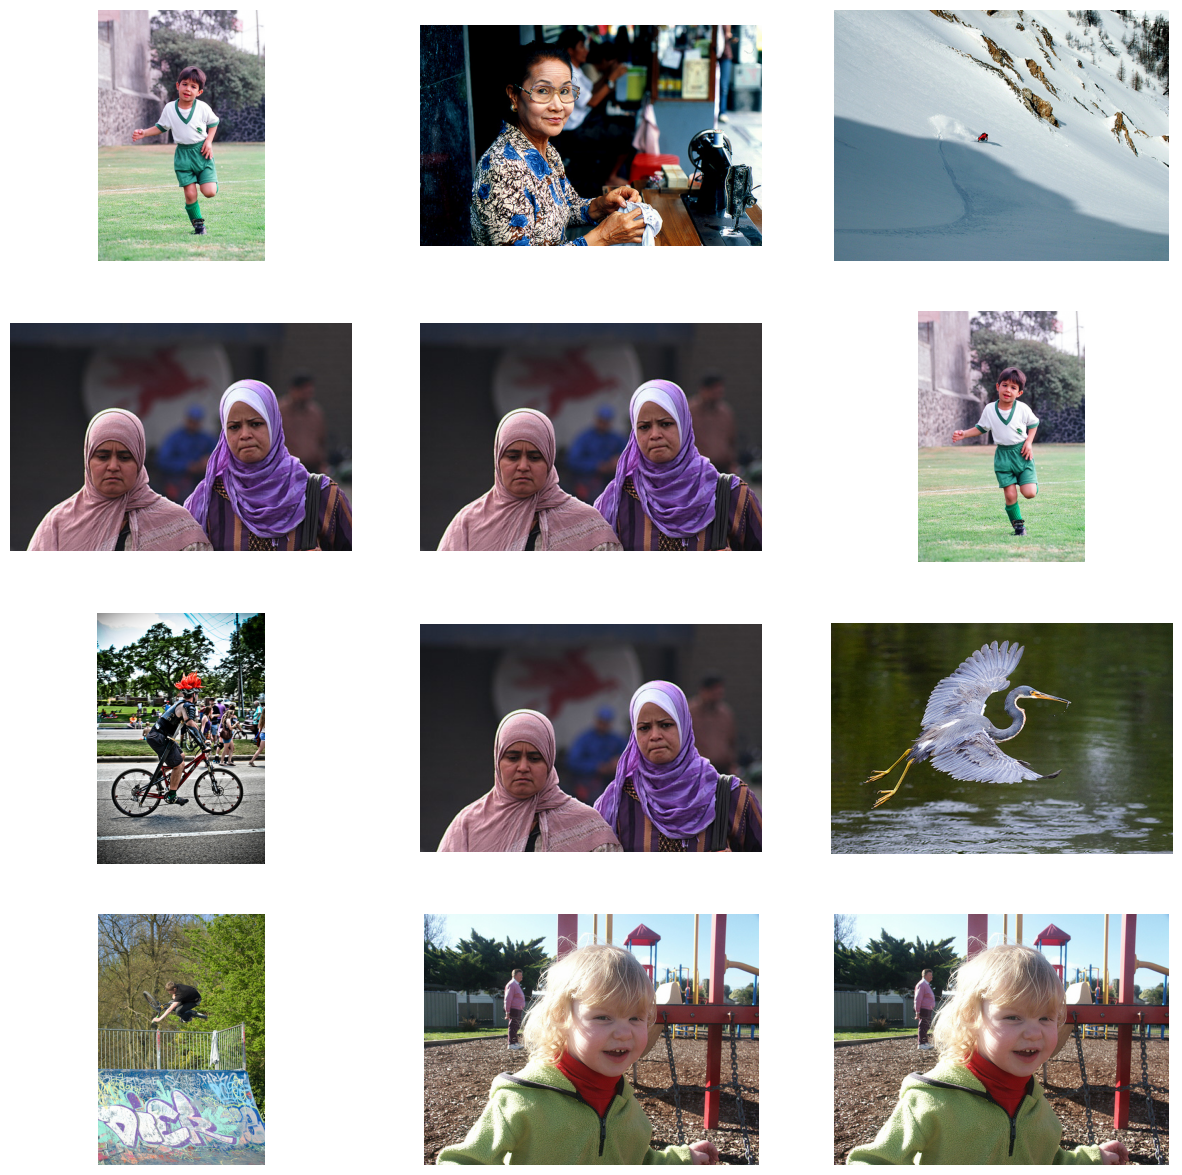

In [26]:
test_transforms = transforms.Compose([
                                # transforms.Resize(255),
                                # transforms.CenterCrop(256),
                                transforms.ToTensor()])

test_images = datasets.ImageFolder(root=os.path.join(path,'test'), 
                                   transform=test_transforms)


figure = plt.figure(figsize=(15, 15))
cols, rows = 3, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_images), size=(1,)).item()
    img, label = test_images[sample_idx]
    
    ax = figure.add_subplot(rows, cols, i)
    # wrapped_title = "\n".join(textwrap.wrap(test_data['query_text'][label], width=30))  
    # ax.set_title(wrapped_title) 
    ax.axis("off")
    
    img = img.permute(1, 2, 0)
    plt.imshow(img.squeeze())
plt.show()

**Вывод по фотографиям** в датасете имеется фотографии похожих, но разных размеров, разной ориентации, вертикальной и горизонтальной, разная тематика фотографий. Но нас больше всего интересует, что в датасетах довольно много фотографий детей

Вероятно имеет смысл привести эти датасеты к единому размеру - например квадрат 320х320 , т.к. исходные фотографии имеют размер 500х325 или 323х500

### Вывод по 

Всего у нас 5 датасетов:

    - `train_data` - Этот датасет состоит 5822 строк - 1000 уникальных изображений, 977 уникальных описаний к ним. К каждому изображению имеется 5-6 описаний
    - `test_images` - здесь просто наименования изображений. Всего 100 уникальных изображений
    - `crowd_annotations` - это датасет с разметкой 1000 изображений из тренировочного датасета путем краудсорсинга. Длина датасета - 47830 записей, что говорит о том, что каждое изображение сопоставлялось с 40-50 описаниями. По результатам этих описаний имеется рейтинг соответствия изображений с описаниями от 0 до 1
    - `expert_annotations` - датасет с разметкой экспертов. Судя по размеру выборки, а также по количеству уникальных изобаржений и запросов видно, что экспериты размечали именно тренировочный датасет
    - `test_queries` - датасет с информацией для тесторования - 100 уникальных изображений и 500 уникальных запросов. Необходимо поставить зависиомсть

По условию нам необходимо предоставить проект, в котором будет модель, на выходе дающая число от 0 до 1 - степень соответствия картинки и текста. 
В этом смысле в качестве обучающих данных удобно пользоваться данными краудсорсинга - там уже в разметке есть число от 0 до 1.
А вот с точки зрения соответствия описания и тренирочных данных определенно удобно использовать разметку экспертов, тк там используется именно тренировочный датасет. 
Однако агрегированной оценки нет, а каждый эксперт выставлял степень соответствия баллами - от 1 до 4 - по сути классифицировал. Агрегированием оценки займемся как раз в следующем пункте. 

Судя по постановке задачи, необходимо решить задачу регрессии

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


### Вариант агрегирования экспертных оценок

Я бегло просмотрел варианты агрегирования экспертных оценок, увидел метод Борда, медиану Кемени и т.д. Мне показалось, что их целесообразно применять в случае, когда у нас есть в том числе критерии оценки каждого объекта, а также большее количество экспертов.

В случае данной задачи, когда у нас всего 3 эксперта, которых мы считаем по умолчанию одинаково компетентными в вопросах выставления оценок, и только одна оценка (без дополнительных критериев), считаю, что можно поступить проще и по сути взять некоторую среднюю оценку, затем привести ее к диапазону [0 , 1]. В таком случае можно не исключать пары датасета в случае, если все три оценки разные

Тем не менее посмотрим сколько таких пар "изображение-описание", где оценки экспертов расходятся

In [27]:
coincidence = []
for i in range(len(expert_ann)):
    if ((expert_ann['1_exp'][i] != expert_ann['2_exp'][i])
    and (expert_ann['1_exp'][i] != expert_ann['3_exp'][i]) 
    and (expert_ann['2_exp'][i] != expert_ann['3_exp'][i])):
        coincidence.append(i)
print('Количество пар "изображение-описание" с полностью разными оценками экспертов:', len(coincidence))
        

Количество пар "изображение-описание" с полностью разными оценками экспертов: 126


Посмотрим на эти пары

In [28]:
expert_ann.loc[[*coincidence], :].head(10)

image                     query_id  1_exp  2_exp  \
17   1082379191_ec1e53f996.jpg  1536774449_e16b1b6382.jpg#2      1      2   
40   1119015538_e8e796281e.jpg  2534502836_7a75305655.jpg#2      2      3   
47   1122944218_8eb3607403.jpg  3325497914_f9014d615b.jpg#2      2      3   
168  1287475186_2dee85f1a5.jpg  2918769188_565dd48060.jpg#2      1      2   
199  1329832826_432538d331.jpg  1536774449_e16b1b6382.jpg#2      1      2   
262   136886677_6026c622eb.jpg  2877503811_4e311253ec.jpg#2      1      2   
266   136886677_6026c622eb.jpg   354642192_3b7666a2dd.jpg#2      1      2   
269   136886677_6026c622eb.jpg   801607443_f15956d1ce.jpg#2      1      2   
287  1389264266_8170bc1c54.jpg  2666179615_f05a9d8331.jpg#2      1      2   
401  1472230829_803818a383.jpg   354642192_3b7666a2dd.jpg#2      1      2   

     3_exp  
17       3  
40       4  
47       4  
168      3  
199      3  
262      3  
266      3  
269      3  
287      3  
401      3

Посмотрим нет ли ошибок в оценках экспертов, не выходят ли они за пределы диапазона от 1 до 4

In [29]:
print('Минимальная оценка 1 эксперта в датасете:', expert_ann['1_exp'].min())
print('Максмальная оценка 1 эксперта в датасете:', expert_ann['1_exp'].max())
print()
print('Минимальная оценка 2 эксперта в датасете:', expert_ann['2_exp'].min())
print('Максмальная оценка 2 эксперта в датасете:', expert_ann['2_exp'].max())
print()
print('Минимальная оценка 3 эксперта в датасете:', expert_ann['2_exp'].min())
print('Максмальная оценка 3 эксперта в датасете:', expert_ann['2_exp'].max())

Минимальная оценка 1 эксперта в датасете: 1
Максмальная оценка 1 эксперта в датасете: 4

Минимальная оценка 2 эксперта в датасете: 1
Максмальная оценка 2 эксперта в датасете: 4

Минимальная оценка 3 эксперта в датасете: 1
Максмальная оценка 3 эксперта в датасете: 4


С оценками экспертов все в порядке

 Видно что в таких случаях оценки экспертов варьируются в пределах двойки: максимальная оценка отличается от минимальной не более, чем на 2. в среднем получается та оценка, которую выставил "средний эксперт". 

Кстати что интересно, судя по оценкам, первый эксперт подходит наиболее строго к оцениванию соответствия результатов, а третий, напротив, наиболее мягко - его оценка соответствия всегда выше. в таком случае действительно можно взять среднее арифметическое, деленное на 4. Да и проще

Предлагаю поступить следующим образом. Визуализирую ниже:

    - у нас есть 4 оценки - от 1 до 4, где 1 - полное несоответствие, а 4 - полное соответствие, тогда если мы нанесем эти оценки на шкалу от 1 до 4, то у нас будет три равных по длине интервала, где оценка 2 соответствует 33% степени соответствия, а оценка 3 - 66%.

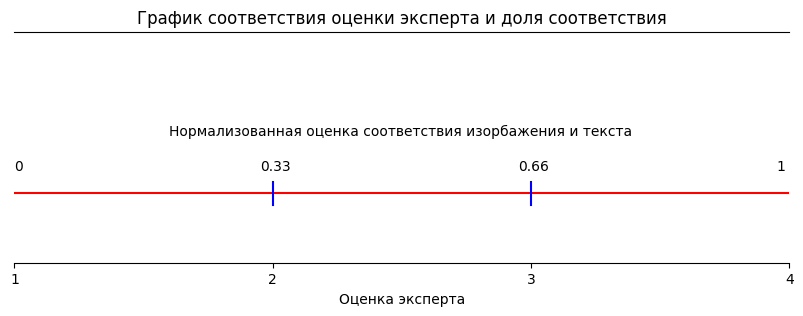

In [30]:
fig, ax = plt.subplots(figsize=(10, 3))

plt.axhline(y=0.3, color='r', linestyle='-', xmin=0, xmax=4)
plt.axvline(x=2, color='b', ymin=0.25, ymax=0.35)
plt.axvline(x=3, color='b', ymin=0.25, ymax=0.35)

ax.set_xticks([1,2,3,4])
plt.xlabel('Оценка эксперта')
plt.title('График соответствия оценки эксперта и доля соответствия')

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.yaxis.set_visible(False)
ax.set_xlim([1, 4])

plt.text(1.0, 0.4, '0', fontsize=10)
plt.text(1.95, 0.4, '0.33', fontsize=10)
plt.text(2.95, 0.4, '0.66', fontsize=10)
plt.text(3.95, 0.4, '1', fontsize=10)

plt.text(1.6, 0.55, 'Нормализованная оценка соответствия изорбажения и текста', fontsize=10)

plt.show()

Чтобы осуществить такой переход, нужно из оценки эксперта вычесть единицу и поделить на 3 (количество интервалов).

А общую оценку найдем как среднее арифметическое

In [31]:
# Напишем функцию вычитанию единицы из значений оценок
def exp_mod1(data):
    df = data.copy()
    for i in [1,2,3]:
        df[f'{i}_exp'] = round((df[f'{i}_exp'] - 1) / 3, 2)
    return df

#Теперь напишем функцию для расчета степени соответствия
def exp_mod2(row):    
    row['similarity_rate'] = round((row['1_exp'] + row['2_exp'] + row['3_exp']) / 3, 2)
    return row



В итоге получаем датафрейм с количественными оценками экспертов:

In [32]:
exp = exp_mod2(exp_mod1(expert_ann))
exp.head()

image                     query_id  1_exp  2_exp  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2    0.0   0.00   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2    0.0   0.00   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2    0.0   0.00   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2    0.0   0.33   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2    0.0   0.00   

   3_exp  similarity_rate  
0   0.00             0.00  
1   0.33             0.11  
2   0.33             0.11  
3   0.33             0.22  
4   0.33             0.11

In [33]:
print('Минимальная агрегированная оценка экспертов:', exp.iloc[:, 5].min())
print('Максимальная агрегированная оценка экспертов:', exp.iloc[:, 5].max())
print()
print('Список со степенями соответствия изображения и описания согласно экспертной оценке')
print(sorted(exp.iloc[:, 5].unique()))

Минимальная агрегированная оценка экспертов: 0.0
Максимальная агрегированная оценка экспертов: 1.0

Список со степенями соответствия изображения и описания согласно экспертной оценке
[0.0, 0.11, 0.22, 0.33, 0.44, 0.45, 0.55, 0.56, 0.67, 0.78, 0.89, 1.0]


### Промежуточный вывод по исследовательскому анализу

Как итог мы теперь имеем нормализованную количественную оценку соответствия изображений и описания согласно экспертам и согласно данным краудсорсинга

Эксперты размечали строго тренировочную выборку - 5822 пары "изображение-описание"
Краудсорсингом размечено больше 47 тысяч пар, при этом фотографий столько же, сколько и в экспертном датасете, сколько и в тренировочной выборке - ровно 1000

Отсюда возникает два пути.

    1) Для обучения модели можно использовать только экспертную выборку, которая полностью совпадает с тренировочной выборкой и по сути дает разметку для нее
    
    2) Можно использовать оценку и экспертов, и краудсорсинга, при этом оставить только пары "изображений-описаний" из тренировочной выборки, а оценкам присвоить разный вес: например, как написано в предложении в этом проекте, для экспертной оценки взять вес 0.6, а для краудсорса - 0.4
    
    3) (думаю использовать в этом проекте не нужно):теоретически можно расширить выборку путем добавления всех пар изображений описаний до краудсорсинговой выборки и обучить на расширенном датасете





Теперь объединим таблицы - к таблице с оценкой экспертов присоединим таблицы с оценкой краудсорсинга с типом объединения `left`, чтобы весь датасет с экспертной оценкой вошел в итоговую таблицу. Объединять будем по сочетаниям "изображение-описание"

In [34]:
estimation = exp.merge(crowd_ann, on=['image', 'query_id'], how='left')
estimation.head()

image                     query_id  1_exp  2_exp  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2    0.0   0.00   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2    0.0   0.00   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2    0.0   0.00   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2    0.0   0.33   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2    0.0   0.00   

   3_exp  similarity_rate_x  similarity_rate_y  yes_num  no_num  
0   0.00               0.00                0.0      0.0     3.0  
1   0.33               0.11                0.0      0.0     3.0  
2   0.33               0.11                NaN      NaN     NaN  
3   0.33               0.22                NaN      NaN     NaN  
4   0.33               0.11                NaN      NaN     NaN

In [35]:
print('Длина объединенного датасета:', len(estimation))

Длина объединенного датасета: 5822


In [36]:
estimation.isna().sum()

image                   0
query_id                0
1_exp                   0
2_exp                   0
3_exp                   0
similarity_rate_x       0
similarity_rate_y    3493
yes_num              3493
no_num               3493
dtype: int64

Видно, что длина объединенного датасета равна длине датасета с разметкой экспертов

Кроме того, видны в объединенном датасете пропуски (3493 строки) в столбцах из оценки краудсорсинга - это значит, что таких пар "изображение-описание" там нет. 

Опять же учитывая, что тренировочный датасет совпадает с размеченным экспертами - будем использовать только экспертный датасет

Объединим тренировочный датасет с экспертной разметкой:

In [37]:
estimation = train_data.merge(exp, on=['image', 'query_id'])
estimation.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  1_exp  2_exp  3_exp  \
0  A young child is wearing blue goggles and sitt...    0.0   0.00   0.00   
1  A young child is wearing blue goggles and sitt...    0.0   0.00   0.00   
2  A young child is wearing blue goggles and sitt...    0.0   0.33   0.33   
3  A young child is wearing blue goggles and sitt...    1.0   1.00   1.00   
4  A young child is wearing blue goggles and sitt...    0.0   0.00   0.00   

   similarity_rate  
0             0.00  
1             0.00  
2             0.22  
3             1.00  
4             0.00

In [38]:
estimation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            5822 non-null   object 
 1   query_id         5822 non-null   object 
 2   query_text       5822 non-null   object 
 3   1_exp            5822 non-null   float64
 4   2_exp            5822 non-null   float64
 5   3_exp            5822 non-null   float64
 6   similarity_rate  5822 non-null   float64
dtypes: float64(4), object(3)
memory usage: 318.5+ KB


Пропусков нет, но необходимо убрать лишние столбцы

In [39]:
def removing(data):
    for i in [1,2,3]:
        try:
            data = data.drop(f'{i}_exp', axis=1)
        except:
            data = data
    return data

In [40]:
estimation = removing(estimation)
estimation.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  similarity_rate  
0  A young child is wearing blue goggles and sitt...             0.00  
1  A young child is wearing blue goggles and sitt...             0.00  
2  A young child is wearing blue goggles and sitt...             0.22  
3  A young child is wearing blue goggles and sitt...             1.00  
4  A young child is wearing blue goggles and sitt...             0.00

In [41]:
print(len(estimation))

5822


**Промежуточный вывод** И так на данном этапе мы имеем размеченный тренировочной датасет.

Нам необходимо (далее по заданию): "Для демонстрационной версии нужно выбрать лучшую  модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу. ". 

Датасет трогать не буду, пусть будет больше данных

Тем не менее **Вопрос:** надо ли оставлять те пары "изображения и описания", где соответствие минимально? Должна ли модель знать, что описание "точно не подходит"? Или все же можно убрать?

#### Проверка соответствия между запросом к своей же фотографии

Как мы помним, запрос состоит из двух частей - номер фотографии и собственно номер запроса. Проверим степень соответствия между ними

In [42]:
iii = []
for i in range(len(estimation)):
    if estimation['image'][i] in estimation['query_id'][i]:
        iii.append(i)


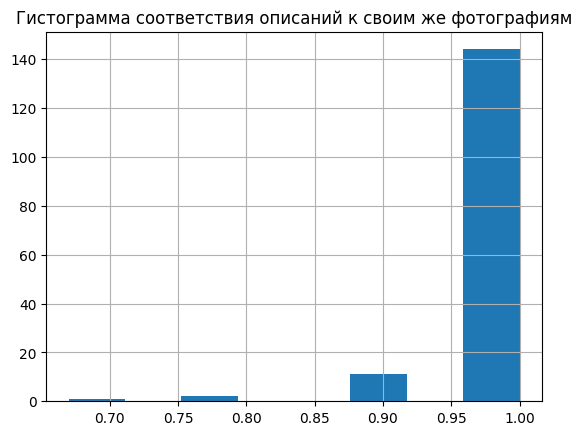

In [43]:
estimation.loc[iii]['similarity_rate'].hist(bins=8)
plt.title('Гистограмма соответствия описаний к своим же фотографиям')
plt.show()

In [44]:
print('Количество пар "фотография и запрос к этой фотографии":',len(estimation.loc[iii]))

Количество пар "фотография и запрос к этой фотографии": 158


Видно, что запросы в основном идеально соответствуют своим фотографиям, но встречается и такое, когда степень соответствия 0.67 - то есть все эксперты выставили оценку 3. 

В итоге у нас всего 158 пар фотографий "фото-запрос именно к ней". Посмотрим на количество фотографий, где степень сходства 0.67, 0.5 и 0.3

In [45]:
print('Количество пар фотографий со сходством больше 0.67:', len(estimation[estimation['similarity_rate'] >= 0.67]))
print('Количество пар фотографий со сходством больше 0.5:', len(estimation[estimation['similarity_rate'] >= 0.5]))
print('Количество пар фотографий со сходством больше 0.3:', len(estimation[estimation['similarity_rate'] >= 0.3]))

Количество пар фотографий со сходством больше 0.67: 623
Количество пар фотографий со сходством больше 0.5: 816
Количество пар фотографий со сходством больше 0.3: 1818


Выбору промежуточное значение - оставлю только те пары фотографий и описаний, где сходство 0.5 и выше. Сходство 0.3 это в общем-то довольно мало

In [46]:
# estimation = estimation[estimation['similarity_rate'] >= 0.5]
# estimation

# Вывод по исследовательскому анализу

В ходе анализа было установлено, что датасет, размеченный экспертами, полностью совпадает с тренировочным датасетом, поэтому будем использовтаь только экспертную разметку

Что касается разметки краудсорсинга - из 5822 сочетаний "изображение-описание" тренироочного датасета всего менее половины есть в датасете, размеченном краудсорсингом, поэтому от его использования решено отказаться

Тем не менее можно отметить, что путем объединения двух датасетов в целом можно увеличить обучающую выборку (на первой итерации проекта делать я этого не буду)

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

### Создание списка слов, попадающих под юридические ограничения

Чтобы не лезть в словарь английского, выберу перевод следующих слов: `ребенок`, `мальчик`, `девочка`, `подросток` и их множественные числа

Получаются следующие слова по переводчику:

    1) Ребенок / дети - kid, child, baby, infant, youngster, children
    
    2) Мальчик - boy, youngster, kid
    
    3) Девочка - girl, girlie
    
    4) Подросток / подростки - teenager, adolescent, adolescence (как общность, что-то вроде "молодежь" или "юнцы"), juvenile, youth

Cоздадим список слов, включающий единственные и множественные формы слов (нвдеюсь нигде не ошибся с формой множественного числа). В целом множественные формы наверно не нужны, тк после лемматизации они должны быть в форме единственного числа, но пусть будет

In [47]:
stopwords = [
    'kid',
    'kids',
    'child',
    'children',
    'baby',
    'babies',
    'infant',
    'infants',
    'youngster',
    'youngsters',
    'boy',
    'boys',
    'girl',
    'girls',
    'girlie',
    'girlies',
    'teenager',
    'teenagers',
    'adolescent',
    'adolescents'
    'adolescence',
    'juvenile',
    'juveniles',
    'youth'   
]

Теперь наша задача удалить изображения с детьми, которые нарушают закон. 

Чтобы точно удалить те самые изображения, нам нужно найти пары "изображение-описание" с указанием детей, где гарантированно есть дети. Для такого порога предлагаю взять порог 0.5

То есть мы находим пары "изображение-описание", соответствующие друг другу более, чем на 0.5, оттуда берем названия изорбажений и удаляем все строки с этими изображениями

Сначала находим датасет с соответствием больше 0.5. Потом попробуем другие пороги 

In [48]:
stop_set = estimation[(estimation['similarity_rate'] > 0.3)]

In [49]:
del_index = []
for word in stopwords:
    for i in stop_set.loc[:, 'query_text'].index:
        if word in stop_set.loc[:, 'query_text'][i]:
            del_index.append(i)
print('Количество строк для удаления:', len(del_index)) 

Количество строк для удаления: 459


Во всем датасете пар "изображение с детьми-описание" со степенью сходства более 0.5 равно 152. То есть нужно удалить всего 152 таких строки.

Если опустить порог степени сходства до 0.3, то изображений будет 459.

Я отдельно проанализировал (строки к сожалению к этому моменту удалил уже), что при степени сходства 0.3 и выше  к описаниям, содержащим "стоп слова с детьми", подходят 90% изображений с детьми. ПОэтому я предлагаю все же взять именно этот порог и удалить 459 строк

Посмотрим на таблицу с этими словами, а точнее на столбец с текстом запроса:

In [50]:
estimation.loc[del_index]

image                     query_id  \
84     106490881_5a2dd9b7bd.jpg  2140182410_8e2a06fbda.jpg#2   
86    2140182410_8e2a06fbda.jpg  2140182410_8e2a06fbda.jpg#2   
87    3113322995_13781860f2.jpg  2140182410_8e2a06fbda.jpg#2   
89    3320032226_63390d74a6.jpg  2140182410_8e2a06fbda.jpg#2   
92    3657016761_d553e514d9.jpg  2140182410_8e2a06fbda.jpg#2   
...                         ...                          ...   
5270  3538213870_9856a76b2a.jpg  2339106348_2df90aa6a9.jpg#2   
5274   523985664_c866af4850.jpg  2339106348_2df90aa6a9.jpg#2   
1402  3301811927_a2797339e5.jpg   494921598_af73bda568.jpg#2   
5171  3388330419_85d72f7cda.jpg  3358558292_6ab14193ed.jpg#2   
5173  3468694409_a51571d621.jpg  3358558292_6ab14193ed.jpg#2   

                                             query_text  similarity_rate  
84                  The kid is on a float in the snow .             0.33  
86                  The kid is on a float in the snow .             1.00  
87                  The kid is on a float in the snow .             0.33  
89                  The kid is on a float in the snow .             0.67  
92                  The kid is on a float in the snow .             0.33  
...                                                 ...              ...  
5270                      The girls were in the crowd .             0.33  
5274                      The girls were in the crowd .             0.33  
1402                           A youth playing hockey .             0.56  
5171  The room full of youths reacts emotionally as ...             0.44  
5173  The room full of youths reacts emotionally as ...             0.67  

[459 rows x 4 columns]

Видим, что строки со стоп словами найдены корректно. Теперь удаляем эти строки, заодно обнулим индексы, они нам в целом не нужны в том порядке, в котороым были в исходной таблице

In [51]:
try:
    estimation = estimation.drop(index=del_index)
    estimation = estimation.reset_index(drop=True)
except:
    estimation = estimation

estimation

image                     query_id  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1     1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2     2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3     2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
4     3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
...                         ...                          ...   
5450   799486353_f665d7b0f0.jpg  2170222061_e8bce4a32d.jpg#2   
5451   799486353_f665d7b0f0.jpg  2196107384_361d73a170.jpg#2   
5452   909808296_23c427022d.jpg  2112921744_92bf706805.jpg#2   
5453   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5454   968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                             query_text  similarity_rate  
0     A young child is wearing blue goggles and sitt...             0.00  
1     A young child is wearing blue goggles and sitt...             0.00  
2     A young child is wearing blue goggles and sitt...             0.22  
3     A young child is wearing blue goggles and sitt...             0.00  
4     A young child is wearing blue goggles and sitt...             0.00  
...                                                 ...              ...  
5450  A small animal leaps behind a larger animal , ...             0.00  
5451          a old man walks down the uncrowded road .             0.00  
5452       A dog stands on the side of a grassy cliff .             0.33  
5453                       A blurry photo of two dogs .             0.56  
5454                        A man rows his boat below .             0.00  

[5455 rows x 4 columns]

### Вывод по удалению слов

Мы взяли тренировочный датасет, разметили его. Составили список слов, обозначающих на английском детей. Нашли пары изображений-описаний с детьми, которые соответствуют друг другу не менее, чем на 0.3. И удалили эти изображения

Длина датасета в такой случае равна 5455 строк, что меньше оригинала на 459 строк (которые мы удалили в результате обработки)

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

Здесь возьмем сеть `ResNet50` и исключим только последний слой. Если исключить 2 (как в примере на сайте практикума (не совсем понимаю почему там именно 2)), то размерность вектора будет чуть больше 100 тыс. А если исключаем только 1 слой, то размер вектора становится равным 2048. А вот если взять `ResNet18` то размер будет уже 512. Но остановимся на `ResNet50`

In [52]:
%%time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

resnet = models.resnet50(pretrained=True)

for param in resnet.parameters():
    param.requires_grad_(False)

modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)

resnet.eval()
resnet.to(device)

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_tensor = []
for i in range(len(estimation['image'])):
    img = Image.open(os.path.join(path, 'train', 'train_images', estimation['image'][i]))
    image_tensor.append(preprocess(img))


output_tensor = []
for i in range(len(image_tensor)):
    image = image_tensor[i].unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = resnet(image).flatten().cpu().numpy()
    output_tensor.append(output)

B:\Users\Alexander\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
B:\Users\Alexander\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CPU times: total: 21.1 s
Wall time: 1min 14s


In [53]:
output_tensor

[array([0.02296309, 0.9206479 , 0.03861446, ..., 0.13621591, 0.17520767,
        0.2561688 ], dtype=float32),
 array([0.14854549, 1.2023659 , 0.1031994 , ..., 0.19043992, 0.81341136,
        0.25929496], dtype=float32),
 array([0.49880093, 1.0002263 , 0.10065524, ..., 0.3800592 , 0.3943535 ,
        0.97136354], dtype=float32),
 array([0.21190684, 2.3731484 , 0.22712474, ..., 0.5656073 , 0.64207304,
        0.2030505 ], dtype=float32),
 array([0.27180848, 2.6512065 , 1.740002  , ..., 0.16003671, 0.27485216,
        0.32493666], dtype=float32),
 array([0.6520471 , 1.7504494 , 1.6962974 , ..., 0.40510255, 0.0692503 ,
        0.3608166 ], dtype=float32),
 array([0.11192985, 0.7316246 , 0.09876415, ..., 0.20445016, 0.3017027 ,
        0.08507624], dtype=float32),
 array([0.04531703, 1.1944203 , 0.5036379 , ..., 0.25827068, 0.5740794 ,
        0.6478671 ], dtype=float32),
 array([0.71781343, 0.59857434, 0.23655327, ..., 0.02936616, 0.30342346,
        0.26585594], dtype=float32),
 array([0.

In [54]:
pd.Series(output_tensor).shape

(5455,)

In [55]:
image_vector = output_tensor

In [56]:
print('Длина вектора изображения:', len(image_vector[0]))

Длина вектора изображения: 2048


### Вывод по векторизации изображений

Для векторизации изображений взяли модель ResNet50, заморозили в ней слои, чтобы не происходло обучение, при этом взяли все модули из архитектуры сети, кроме последнего

На выходе получили список векторов, состоящи `image_vector`, имеющий размерность 5455x2048. 5 - количество строк в датасете, 2048 - количество элементов в векторе после прохождения предпоследнего слоя в ResNet50. 

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


### Векторизация с помощью BERT

Я решил попробовать векторизовать тексты с помощью BERT, для этого взял самую скачиваемую модель (https://huggingface.co/google-bert/bert-base-uncased)

Здесь загрузим модель и токенизатор

In [57]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")

Дальше напишем функцию, которая будет векторизовать строки в нашем датасете

In [58]:
def tokenization(row):    
    row['query_vector'] = tokenizer.encode(row['query_text'], add_special_tokens=True)
    return row

In [59]:
estimation = estimation.apply(tokenization, axis=1)
estimation.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
4  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  similarity_rate  \
0  A young child is wearing blue goggles and sitt...             0.00   
1  A young child is wearing blue goggles and sitt...             0.00   
2  A young child is wearing blue goggles and sitt...             0.22   
3  A young child is wearing blue goggles and sitt...             0.00   
4  A young child is wearing blue goggles and sitt...             0.00   

                                        query_vector  
0  [101, 1037, 2402, 2775, 2003, 4147, 2630, 2175...  
1  [101, 1037, 2402, 2775, 2003, 4147, 2630, 2175...  
2  [101, 1037, 2402, 2775, 2003, 4147, 2630, 2175...  
3  [101, 1037, 2402, 2775, 2003, 4147, 2630, 2175...  
4  [101, 1037, 2402, 2775, 2003, 4147, 2630, 2175...

Видим, что строки векторизованы, в начале и в конце стоят специальные токены начала и конца текста (101 и 102). Так как тексты разные, посмотрим на длины этих векторов

In [60]:
def vec_len(row):
    row['vector_len'] = len(row['query_vector'])
    return row

In [61]:
estimation = estimation.apply(vec_len, axis=1)
estimation.tail()

image                     query_id  \
5450  799486353_f665d7b0f0.jpg  2170222061_e8bce4a32d.jpg#2   
5451  799486353_f665d7b0f0.jpg  2196107384_361d73a170.jpg#2   
5452  909808296_23c427022d.jpg  2112921744_92bf706805.jpg#2   
5453  929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5454  968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                             query_text  similarity_rate  \
5450  A small animal leaps behind a larger animal , ...             0.00   
5451          a old man walks down the uncrowded road .             0.00   
5452       A dog stands on the side of a grassy cliff .             0.33   
5453                       A blurry photo of two dogs .             0.56   
5454                        A man rows his boat below .             0.00   

                                           query_vector  vector_len  
5450  [101, 1037, 2235, 4111, 29195, 2369, 1037, 346...          27  
5451  [101, 1037, 2214, 2158, 7365, 2091, 1996, 4895...          13  
5452  [101, 1037, 3899, 4832, 2006, 1996, 2217, 1997...          13  
5453  [101, 1037, 14819, 2854, 6302, 1997, 2048, 607...          10  
5454  [101, 1037, 2158, 10281, 2010, 4049, 2917, 101...           9

Видим, что длина векторов разная, поэтому нам надо привести длину векторов к единой с помощью техники `padding`. 

Чтобы сделать все длины векторов одинаковыми, найдем для начала наибольшую длину:

In [62]:
estimation['vector_len'].max()

36

Максимальная длина у нас - 36, поэтому сделаем длину всех векторов 36, дополним нулями

Для этого напишем функцию, где наш вектор дополняется нулями, после этого обновим столбец с длиной вектора, применив к нему выше написанную функцию vec_len, чтобы оценить изменения

In [63]:
def pad_text(row):
    n=36
    row['query_vector'] = np.array(row['query_vector'] + [0]*(n - len(row['query_vector'])))
    return row

In [64]:
estimation = estimation.apply(pad_text, axis=1)
estimation = estimation.apply(vec_len, axis=1)
estimation.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
4  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  similarity_rate  \
0  A young child is wearing blue goggles and sitt...             0.00   
1  A young child is wearing blue goggles and sitt...             0.00   
2  A young child is wearing blue goggles and sitt...             0.22   
3  A young child is wearing blue goggles and sitt...             0.00   
4  A young child is wearing blue goggles and sitt...             0.00   

                                        query_vector  vector_len  
0  [101, 1037, 2402, 2775, 2003, 4147, 2630, 2175...          36  
1  [101, 1037, 2402, 2775, 2003, 4147, 2630, 2175...          36  
2  [101, 1037, 2402, 2775, 2003, 4147, 2630, 2175...          36  
3  [101, 1037, 2402, 2775, 2003, 4147, 2630, 2175...          36  
4  [101, 1037, 2402, 2775, 2003, 4147, 2630, 2175...          36

И еще на всякий случай посмотрим на какой-нибудь из векторов

In [65]:
estimation['query_vector'][0]

array([  101,  1037,  2402,  2775,  2003,  4147,  2630,  2175, 24989,
        1998,  3564,  1999,  1037, 14257,  1999,  1037,  4770,  1012,
         102,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0])

Создадим теперь attention mask, чтобы указать модели, что 0 не несет смысловой информации

In [66]:
padded = np.array(estimation['query_vector'].to_list())

In [67]:
attention_mask = np.where(padded != 0, 1, 0)
print(attention_mask.shape) 

(5455, 36)


### Создание эмбеддингов

Так как наша выборка имеет размерность 692 строки (padded.shape[0] = 692), то делить на батчи я не вижу смысла

In [68]:
# %%time 

# embeddings = []

# batch_size=50
# for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
#     batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
#     attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

#     with torch.no_grad():
#         batch_embeddings = model(batch, attention_mask=attention_mask_batch)

#     embeddings.append(batch_embeddings[0][:,0,:].numpy()) 

Выше закомментированный код это на CPU, а ниже решил попробовать на GPU (без помощи chatgpt не обошлось). Результат тот же, Только в 15-20 раз быстрее

In [69]:
%%time

# Проверка, доступен ли GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

embeddings = []

# Перенос модели на устройство (GPU, если доступно)
model = model.to(device)


    # Перенос данных на устройство
tens = torch.LongTensor(padded).to(device)
attention_mask_tens = torch.LongTensor(attention_mask).to(device)

# Вычисление эмбеддингов на GPU
with torch.no_grad():
    tens_embeddings = model(tens, attention_mask=attention_mask_tens)

# Перемещение результата обратно на CPU для преобразования в NumPy
embeddings.append(tens_embeddings[0][:, 0, :].cpu().numpy())

Используемое устройство: cuda


B:\Users\Alexander\anaconda3\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


CPU times: total: 2.2 s
Wall time: 4.56 s


In [70]:
embeddings

[array([[-0.04787776,  0.0514148 , -0.2728133 , ...,  0.02095252,
          0.32360232,  0.6049588 ],
        [-0.04787776,  0.0514148 , -0.2728133 , ...,  0.02095252,
          0.32360232,  0.6049588 ],
        [-0.04787776,  0.0514148 , -0.2728133 , ...,  0.02095252,
          0.32360232,  0.6049588 ],
        ...,
        [-0.081583  ,  0.05398403, -0.8222736 , ..., -0.2057074 ,
          0.36305362,  0.26102716],
        [-0.5235596 , -0.27470666, -0.8157727 , ..., -0.14736952,
          0.11889747,  0.0675679 ],
        [-0.06578661,  0.02755446, -0.31210715, ..., -0.31263834,
          0.15028924,  0.29313022]], dtype=float32)]

In [71]:
text_vector = np.concatenate(embeddings)
text_vector.shape

(5455, 768)

### Вывод по векторизации текстов

Векторизацию текстов проводили с помощью BERT. На выход получили список с векторами `text_vector` c размерностью 5455х768.

И вот теперь возникает вопрос, потому что после конкатенации эмбеддингов текстовых у нас вектор является двумерным (матрицей), 1х768.

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

И так есть тренировочный датасет, который в ходе обработки стал иметь название "estimation" (его мы позже переименуем)\
Также есть списки с векторами текстов и с векторами изображений. 

Так как векторизация происходила построчно для датасета, то считаю, что индексация не была нарушена и мы можем спокойно добавить два новых столбца

НО размерность текстового вектора - (5455, 768), а вот размерность вектора изображений - (5455,0)

То есть для текстового редактора вектор является двумерной матрицей, а не одномерным вектором, поэтому надо с этим что-то сделать, чтобы их объединить методом конкатенации

**В описании к заданию сказано: Модель должна принимать на вход конкатенированный вектор, состоящий из векторов описания и изображений**



In [72]:
print('Длина списка с векторами изображений:', len(image_vector))
print('Длина одного вектора изображения:', len(image_vector[0]))

Длина списка с векторами изображений: 5455
Длина одного вектора изображения: 2048


In [73]:
print('Длина списка с векторами текстов:', len(text_vector))
print('Длина одного вектора текстов:', len(text_vector[0]))

Длина списка с векторами текстов: 5455
Длина одного вектора текстов: 768


In [74]:
len(text_vector)

5455

In [75]:
concat_vector = np.array([np.concatenate([text_vector[i], image_vector[i]]) for i in range(len(text_vector))])
concat_vector

array([[-0.04787776,  0.0514148 , -0.2728133 , ...,  0.13621591,
         0.17520767,  0.2561688 ],
       [-0.04787776,  0.0514148 , -0.2728133 , ...,  0.19043992,
         0.81341136,  0.25929496],
       [-0.04787776,  0.0514148 , -0.2728133 , ...,  0.3800592 ,
         0.3943535 ,  0.97136354],
       ...,
       [-0.081583  ,  0.05398403, -0.8222736 , ...,  0.5258483 ,
         0.72581106,  0.15450628],
       [-0.5235596 , -0.27470666, -0.8157727 , ...,  0.43490982,
         0.26638234,  0.21704955],
       [-0.06578661,  0.02755446, -0.31210715, ...,  0.11731245,
         0.50740135,  0.13831154]], dtype=float32)

In [76]:
concat_vector.shape

(5455, 2816)

Размерность конкатенированной матрицы "текст-обображение" теперь 5455х2816

In [77]:
concat_vector[0]

array([-0.04787776,  0.0514148 , -0.2728133 , ...,  0.13621591,
        0.17520767,  0.2561688 ], dtype=float32)

Возвращаясь к условию задачи: модель принимает на вход конкатенированный вектор (мы его получили), теперь осталось по сути создать датафрейм 

In [78]:
train_df = pd.DataFrame(concat_vector)
train_df['image'] = estimation['image']
train_df['target'] = estimation['similarity_rate']
train_df.head()

0         1         2         3         4         5         6  \
0 -0.047878  0.051415 -0.272813 -0.072299  0.047597 -0.743572  0.045497   
1 -0.047878  0.051415 -0.272813 -0.072299  0.047597 -0.743572  0.045497   
2 -0.047878  0.051415 -0.272813 -0.072299  0.047597 -0.743572  0.045497   
3 -0.047878  0.051415 -0.272813 -0.072299  0.047597 -0.743572  0.045497   
4 -0.047878  0.051415 -0.272813 -0.072299  0.047597 -0.743572  0.045497   

          7         8         9  ...      2808      2809      2810      2811  \
0  0.837146 -0.502958 -0.200051  ...  0.557008  0.374859  1.123278  0.276281   
1  0.837146 -0.502958 -0.200051  ...  0.072623  0.719861  0.329719  0.507085   
2  0.837146 -0.502958 -0.200051  ...  0.693313  0.533240  0.747775  0.617076   
3  0.837146 -0.502958 -0.200051  ...  0.012395  1.122135  0.116628  0.466104   
4  0.837146 -0.502958 -0.200051  ...  0.155781  0.808929  0.338735  0.995617   

       2812      2813      2814      2815                      image  target  
0  1.186825  0.136216  0.175208  0.256169  1056338697_4f7d7ce270.jpg    0.00  
1  0.244410  0.190440  0.813411  0.259295  1262583859_653f1469a9.jpg    0.00  
2  0.889643  0.380059  0.394354  0.971364  2447284966_d6bbdb4b6e.jpg    0.22  
3  0.439001  0.565607  0.642073  0.203050  2621415349_ef1a7e73be.jpg    0.00  
4  0.698968  0.160037  0.274852  0.324937  3155451946_c0862c70cb.jpg    0.00  

[5 rows x 2818 columns]

### Вывод по объединению векторов

Мы взяли векторные представления векторов текстов и векторов описаний, объединили их. И создали датафрейм из 2817 признаков и 1 целового признака

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [79]:
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=train_df.drop(columns=['target']), y=train_df['target'], groups=train_df['image']))
train_dff, test_dff = train_df.loc[train_indices], train_df.loc[test_indices]

In [80]:
train_dff.head()

0         1         2         3         4         5         6  \
0 -0.047878  0.051415 -0.272813 -0.072299  0.047597 -0.743572  0.045497   
1 -0.047878  0.051415 -0.272813 -0.072299  0.047597 -0.743572  0.045497   
2 -0.047878  0.051415 -0.272813 -0.072299  0.047597 -0.743572  0.045497   
3 -0.047878  0.051415 -0.272813 -0.072299  0.047597 -0.743572  0.045497   
6 -0.047878  0.051415 -0.272813 -0.072299  0.047597 -0.743572  0.045497   

          7         8         9  ...      2808      2809      2810      2811  \
0  0.837146 -0.502958 -0.200051  ...  0.557008  0.374859  1.123278  0.276281   
1  0.837146 -0.502958 -0.200051  ...  0.072623  0.719861  0.329719  0.507085   
2  0.837146 -0.502958 -0.200051  ...  0.693313  0.533240  0.747775  0.617076   
3  0.837146 -0.502958 -0.200051  ...  0.012395  1.122135  0.116628  0.466104   
6  0.837146 -0.502958 -0.200051  ...  0.671384  0.233847  0.313577  0.056470   

       2812      2813      2814      2815                      image  target  
0  1.186825  0.136216  0.175208  0.256169  1056338697_4f7d7ce270.jpg    0.00  
1  0.244410  0.190440  0.813411  0.259295  1262583859_653f1469a9.jpg    0.00  
2  0.889643  0.380059  0.394354  0.971364  2447284966_d6bbdb4b6e.jpg    0.22  
3  0.439001  0.565607  0.642073  0.203050  2621415349_ef1a7e73be.jpg    0.00  
6  1.831101  0.204450  0.301703  0.085076   343218198_1ca90e0734.jpg    0.00  

[5 rows x 2818 columns]

In [81]:
test_dff.head()

0         1         2         3         4         5         6  \
4  -0.047878  0.051415 -0.272813 -0.072299  0.047597 -0.743572  0.045497   
5  -0.047878  0.051415 -0.272813 -0.072299  0.047597 -0.743572  0.045497   
8  -0.047878  0.051415 -0.272813 -0.072299  0.047597 -0.743572  0.045497   
10  0.306461  0.187396 -0.317480 -0.147754  0.092267 -0.241826  0.248196   
16  0.225944 -0.147770 -0.410426  0.009855  0.024526 -0.012761 -0.160295   

           7         8         9  ...      2808      2809      2810      2811  \
4   0.837146 -0.502958 -0.200051  ...  0.155781  0.808929  0.338735  0.995617   
5   0.837146 -0.502958 -0.200051  ...  0.275802  0.384849  1.066641  0.171523   
8   0.837146 -0.502958 -0.200051  ...  0.117823  0.080001  0.319850  0.246232   
10  0.775115 -0.397221 -0.463749  ...  0.748889  1.783939  0.262104  0.617121   
16  1.200928 -0.407790 -0.553016  ...  0.142103  0.430213  1.072013  0.176804   

        2812      2813      2814      2815                      image  target  
4   0.698968  0.160037  0.274852  0.324937  3155451946_c0862c70cb.jpg    0.00  
5   0.373586  0.405103  0.069250  0.360817  3222041930_f642f49d28.jpg    0.00  
8   0.246825  0.029366  0.303423  0.265856   486712504_36be449055.jpg    0.00  
10  0.419865  1.817147  0.829166  0.809473  2616643090_4f2d2d1a44.jpg    0.00  
16  0.256822  0.061367  0.087407  0.504445   488590040_35a3e96c89.jpg    0.22  

[5 rows x 2818 columns]

Во мы получили два датасете с огромным количеством признаком и таргетом

In [82]:
X_train = train_dff.drop(['image', 'target'], axis=1)
X_test = test_dff.drop(['image', 'target'], axis=1)
y_train = train_dff['target']
y_test = test_dff['target']

In [83]:
X_train.head()

0         1         2         3         4         5         6     \
0 -0.047878  0.051415 -0.272813 -0.072299  0.047597 -0.743572  0.045497   
1 -0.047878  0.051415 -0.272813 -0.072299  0.047597 -0.743572  0.045497   
2 -0.047878  0.051415 -0.272813 -0.072299  0.047597 -0.743572  0.045497   
3 -0.047878  0.051415 -0.272813 -0.072299  0.047597 -0.743572  0.045497   
6 -0.047878  0.051415 -0.272813 -0.072299  0.047597 -0.743572  0.045497   

       7         8         9     ...      2806      2807      2808      2809  \
0  0.837146 -0.502958 -0.200051  ...  0.037461  0.702758  0.557008  0.374859   
1  0.837146 -0.502958 -0.200051  ...  0.875856  0.293688  0.072623  0.719861   
2  0.837146 -0.502958 -0.200051  ...  0.234549  0.573501  0.693313  0.533240   
3  0.837146 -0.502958 -0.200051  ...  0.273638  0.304530  0.012395  1.122135   
6  0.837146 -0.502958 -0.200051  ...  0.456491  0.392179  0.671384  0.233847   

       2810      2811      2812      2813      2814      2815  
0  1.123278  0.276281  1.186825  0.136216  0.175208  0.256169  
1  0.329719  0.507085  0.244410  0.190440  0.813411  0.259295  
2  0.747775  0.617076  0.889643  0.380059  0.394354  0.971364  
3  0.116628  0.466104  0.439001  0.565607  0.642073  0.203050  
6  0.313577  0.056470  1.831101  0.204450  0.301703  0.085076  

[5 rows x 2816 columns]

In [84]:
y_train.head()

0    0.00
1    0.00
2    0.22
3    0.00
6    0.00
Name: target, dtype: float64

In [85]:
X_test.head()

0         1         2         3         4         5         6     \
4  -0.047878  0.051415 -0.272813 -0.072299  0.047597 -0.743572  0.045497   
5  -0.047878  0.051415 -0.272813 -0.072299  0.047597 -0.743572  0.045497   
8  -0.047878  0.051415 -0.272813 -0.072299  0.047597 -0.743572  0.045497   
10  0.306461  0.187396 -0.317480 -0.147754  0.092267 -0.241826  0.248196   
16  0.225944 -0.147770 -0.410426  0.009855  0.024526 -0.012761 -0.160295   

        7         8         9     ...      2806      2807      2808      2809  \
4   0.837146 -0.502958 -0.200051  ...  0.284373  0.661157  0.155781  0.808929   
5   0.837146 -0.502958 -0.200051  ...  0.229437  0.099568  0.275802  0.384849   
8   0.837146 -0.502958 -0.200051  ...  0.053838  0.067896  0.117823  0.080001   
10  0.775115 -0.397221 -0.463749  ...  1.010657  0.086090  0.748889  1.783939   
16  1.200928 -0.407790 -0.553016  ...  0.353755  0.289773  0.142103  0.430213   

        2810      2811      2812      2813      2814      2815  
4   0.338735  0.995617  0.698968  0.160037  0.274852  0.324937  
5   1.066641  0.171523  0.373586  0.405103  0.069250  0.360817  
8   0.319850  0.246232  0.246825  0.029366  0.303423  0.265856  
10  0.262104  0.617121  0.419865  1.817147  0.829166  0.809473  
16  1.072013  0.176804  0.256822  0.061367  0.087407  0.504445  

[5 rows x 2816 columns]

In [86]:
y_test.head()

4     0.00
5     0.00
8     0.00
10    0.00
16    0.22
Name: target, dtype: float64

### Линейная регрессия 

Возьмем линейную регрессию из torch. В качестве функции потерь будем использовать RMSE

In [87]:
y_train_tensor = torch.from_numpy(y_train.values).float()
X_train_tensor = torch.from_numpy(X_train.values).float()
y_test_tensor = torch.from_numpy(y_test.values).float()
X_test_tensor = torch.from_numpy(X_test.values).float()

print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_train_tensor.shape[1])

torch.Size([3819, 2816])
torch.Size([3819])
2816


In [88]:
class LinearRegression(nn.Module):
    def __init__(self, inputSize, outputSize):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(inputSize, outputSize)

    def forward(self, X):
        return self.linear(X)

def RMSELoss(y_pred, y_true):
    return torch.sqrt(nn.MSELoss()(y_pred, y_true))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = X_train_tensor.shape[1] 
output_size = 1 
learning_rate = 0.0001  
epochs = 200

model_lin = LinearRegression(input_size, output_size).to(device)

criterion = RMSELoss
optimizer = optim.Adam(model_lin.parameters(), lr=learning_rate) 

X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

for epoch in range(epochs):
    model_lin.train()  
    optimizer.zero_grad() 
    predictions = model_lin(X_train_tensor)  
    loss = criterion(predictions.squeeze(), y_train_tensor) 
    loss.backward() 
    optimizer.step()

    model_lin.eval() 
    with torch.no_grad(): 
        val_predictions = model_lin(X_test_tensor) 
        val_loss = criterion(val_predictions.squeeze(), y_test_tensor) 

    if (epoch + 1) % (epochs / 10) == 0:
        print(f'Epoch {epoch+1}/{epochs}, Train RMSE: {loss.item()}, Val RMSE: {val_loss.item()}')


Epoch 20/200, Train RMSE: 0.29422107338905334, Val RMSE: 0.28795233368873596
Epoch 40/200, Train RMSE: 0.2728692293167114, Val RMSE: 0.2720603346824646
Epoch 60/200, Train RMSE: 0.2590371370315552, Val RMSE: 0.26283779740333557
Epoch 80/200, Train RMSE: 0.2495633363723755, Val RMSE: 0.25769537687301636
Epoch 100/200, Train RMSE: 0.24271641671657562, Val RMSE: 0.25422731041908264
Epoch 120/200, Train RMSE: 0.23753869533538818, Val RMSE: 0.2517326772212982
Epoch 140/200, Train RMSE: 0.23346178233623505, Val RMSE: 0.24999961256980896
Epoch 160/200, Train RMSE: 0.23013494908809662, Val RMSE: 0.2487582415342331
Epoch 180/200, Train RMSE: 0.22733961045742035, Val RMSE: 0.2478587031364441
Epoch 200/200, Train RMSE: 0.22493630647659302, Val RMSE: 0.24722324311733246


Видим, что на тренировочном датасете RMSE 0.24, а на валидационном 0.25. Учитывая, что целевая переменная у нас меняется в диапазоне [0, 1] - это довольно много. Попробуем теперь NN

### Нейронная сеть

Построим теперь полносвязную нейросеть из трех полносвязных слоев

In [89]:
class Baseline(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Baseline, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.act1 = nn.ELU()
        
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.act2 = nn.ELU()
        
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.act3 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x) 
        return x

def RMSELoss(y_pred, y_true):
    return torch.sqrt(nn.MSELoss()(y_pred, y_true))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = X_train_tensor.shape[1] 
hidden_size = 128 
output_size = 1 
learning_rate = 0.0001 
epochs = 100

model_nn = Baseline(input_size, hidden_size, output_size).to(device)

criterion = RMSELoss 
optimizer = optim.Adam(model_nn.parameters(), lr=learning_rate) 

X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

for epoch in range(epochs):
    model_nn.train()  
    optimizer.zero_grad() 
    predictions = model_nn(X_train_tensor)
    loss = criterion(predictions.squeeze(), y_train_tensor)
    loss.backward() 
    optimizer.step()

    model_nn.eval() 
    with torch.no_grad():
        val_predictions = model_nn(X_test_tensor) 
        val_loss = criterion(val_predictions.squeeze(), y_test_tensor) 

    if (epoch + 1) % (epochs / 10) == 0:
        print(f'Epoch {epoch+1}/{epochs}, Train RMSE: {loss.item()}, Val RMSE: {val_loss.item()}')

Epoch 10/100, Train RMSE: 0.27819862961769104, Val RMSE: 0.2752663791179657
Epoch 20/100, Train RMSE: 0.25184959173202515, Val RMSE: 0.2517440617084503
Epoch 30/100, Train RMSE: 0.2438984513282776, Val RMSE: 0.24268916249275208
Epoch 40/100, Train RMSE: 0.23990856111049652, Val RMSE: 0.2392529398202896
Epoch 50/100, Train RMSE: 0.23653177917003632, Val RMSE: 0.23755520582199097
Epoch 60/100, Train RMSE: 0.2333272248506546, Val RMSE: 0.23621751368045807
Epoch 70/100, Train RMSE: 0.22991235554218292, Val RMSE: 0.23545953631401062
Epoch 80/100, Train RMSE: 0.22679825127124786, Val RMSE: 0.23533816635608673
Epoch 90/100, Train RMSE: 0.2237902581691742, Val RMSE: 0.23475754261016846
Epoch 100/100, Train RMSE: 0.22085797786712646, Val RMSE: 0.23450712859630585


Ситауция не сильно лучше, чем с регрессией

### Вывод по обучению моделей

Для обучения была выбрана модель линейной регрессии и полносвязная нейронная сеть. 
В качестве функции потерь была выбрана RMSE

Результат обеих моделей сомнительный (пока не знаю почему). Результат у моделей близкий, но RMSE на нейронной сети чуть ниже - 0.235 на валидации. Ее и выберем

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

Идея для тестирования следующая

У нас есть таблица с 100 уникаьлными изорбажениями: мы получаем эмбеддинги изображений и присоединяем эту таблицу саму к себе 10 раз (10 потому что у нас столько уникальных текстовым запросов). Получаем таблицу, в которой 1000 строк.

Потом работаем с таблицей с текстами. Там у нас 10 строк с 10 уникальными текстами. Ее мы присоединяем саму к себе 100 раз (тк 100 уникальных изображений). Получаем эмбеддинги. 

Далее соединяем эти таблицы таким образом, чтобы на каждое уникальное изорбажение приходилось по 10 уникальных текстов. Далее конкатенируем векторы текстов и изображений (так как при обучении моделей было). и проверяем работу модели, создаем в итоговом датасете столбец с предскзаниями. Выбираем наиболее подходящие изображения к 10 выбранным описаниям - смотрим на соответствие и выводим на экран, чтобы оценить соответствие еще и визуально

### Эмбеддинги изображений

Повторим для получения эмбеддингов изображений и текстов те же действия, что и для трейна

У нас всего 100 уникальных тестовых изображений

Сначала создадим датафрейм с уникальными наименованиями изображений

In [90]:
unique_images = test_queries['image'].unique()
test_image_df = pd.DataFrame(unique_images, columns=['image'], index=np.arange(len(unique_images)))
test_image_df

image
0   1177994172_10d143cb8d.jpg
1   1232148178_4f45cc3284.jpg
2    123997871_6a9ca987b1.jpg
3   1319634306_816f21677f.jpg
4   1429546659_44cb09cbe2.jpg
..                        ...
95   862177617_c2c0581075.jpg
96   957682378_46c3b07bcd.jpg
97   973827791_467d83986e.jpg
98   989754491_7e53fb4586.jpg
99   989851184_9ef368e520.jpg

[100 rows x 1 columns]

Будем использовать ту же модель (ячейку с кодом просто скопирую сюда просто скопирую)

In [91]:
%%time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

resnet = models.resnet50(pretrained=True)

for param in resnet.parameters():
    param.requires_grad_(False)

modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)

resnet.eval()
resnet.to(device)

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_tensor = []
for i in range(len(test_image_df)):
    img = Image.open(os.path.join(path, 'test', 'test_images', test_image_df['image'][i]))
    image_tensor.append(preprocess(img))

output_tensor = []
for i in range(len(image_tensor)):
    image = image_tensor[i].unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = resnet(image).flatten().cpu().numpy()
    output_tensor.append(output)

B:\Users\Alexander\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
B:\Users\Alexander\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CPU times: total: 703 ms
Wall time: 1.74 s


In [92]:
image_vector = output_tensor
print('Длина вектора изображения:', len(image_vector[0]))

Длина вектора изображения: 2048


In [93]:
pd.Series(image_tensor).shape

(100,)

In [94]:
image_vector

[array([0.51399255, 1.394091  , 0.39693996, ..., 0.29762882, 0.44469786,
        0.48225963], dtype=float32),
 array([0.09532943, 0.5890093 , 0.06307557, ..., 0.61081874, 0.33468097,
        0.24959886], dtype=float32),
 array([0.2651418 , 0.5830485 , 0.26089653, ..., 0.02368451, 1.1009583 ,
        0.40230167], dtype=float32),
 array([0.01297906, 0.5913329 , 0.12791094, ..., 0.07678203, 0.10407028,
        0.26550004], dtype=float32),
 array([0.23212   , 0.69268405, 0.805376  , ..., 0.24060453, 0.37695047,
        0.08907159], dtype=float32),
 array([0.96477675, 1.4793922 , 1.2866625 , ..., 0.12837365, 0.1761176 ,
        0.69276357], dtype=float32),
 array([0.63147277, 0.67790884, 0.48528138, ..., 0.50153494, 0.7825954 ,
        0.23703502], dtype=float32),
 array([0.10196616, 0.856302  , 0.354318  , ..., 0.08371084, 0.2600431 ,
        0.24794713], dtype=float32),
 array([0.09834699, 0.6462361 , 0.4125177 , ..., 0.36476243, 0.45804882,
        0.682002  ], dtype=float32),
 array([0.

In [95]:
test_image_df['image_vector'] = image_vector
test_image_df.head()

image  \
0  1177994172_10d143cb8d.jpg   
1  1232148178_4f45cc3284.jpg   
2   123997871_6a9ca987b1.jpg   
3  1319634306_816f21677f.jpg   
4  1429546659_44cb09cbe2.jpg   

                                        image_vector  
0  [0.51399255, 1.394091, 0.39693996, 0.485553, 0...  
1  [0.095329426, 0.5890093, 0.06307557, 0.3125865...  
2  [0.2651418, 0.5830485, 0.26089653, 0.13542315,...  
3  [0.012979057, 0.5913329, 0.12791094, 0.4718705...  
4  [0.23212, 0.69268405, 0.805376, 0.042834695, 0...

Вот у нас датасейт с названиями изображений и эмбеддингами. Обращаю внимание, что у нас изображения и, соответственно, эмбеддинги к ним, сгруппированы по 10 штук

In [96]:
concatenated_image_df = pd.concat([test_image_df] * 10, ignore_index=True)
concatenated_image_df = concatenated_image_df.sort_values(by='image').reset_index(drop=True)
concatenated_image_df

image  \
0    1177994172_10d143cb8d.jpg   
1    1177994172_10d143cb8d.jpg   
2    1177994172_10d143cb8d.jpg   
3    1177994172_10d143cb8d.jpg   
4    1177994172_10d143cb8d.jpg   
..                         ...   
995   989851184_9ef368e520.jpg   
996   989851184_9ef368e520.jpg   
997   989851184_9ef368e520.jpg   
998   989851184_9ef368e520.jpg   
999   989851184_9ef368e520.jpg   

                                          image_vector  
0    [0.51399255, 1.394091, 0.39693996, 0.485553, 0...  
1    [0.51399255, 1.394091, 0.39693996, 0.485553, 0...  
2    [0.51399255, 1.394091, 0.39693996, 0.485553, 0...  
3    [0.51399255, 1.394091, 0.39693996, 0.485553, 0...  
4    [0.51399255, 1.394091, 0.39693996, 0.485553, 0...  
..                                                 ...  
995  [0.243602, 1.1735722, 1.0848587, 0.165407, 0.3...  
996  [0.243602, 1.1735722, 1.0848587, 0.165407, 0.3...  
997  [0.243602, 1.1735722, 1.0848587, 0.165407, 0.3...  
998  [0.243602, 1.1735722, 1.0848587, 0.165407, 0.3...  
999  [0.243602, 1.1735722, 1.0848587, 0.165407, 0.3...  

[1000 rows x 2 columns]

### Получение эмбеддингов текстов

Посмотрим снова на файл test_queries

In [97]:
test_queries.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [98]:
len(test_queries['query_text'].unique())

500

У нас 500 уникальных текстов. Нам нужно взять 10 запросов и для этих запросов вывести изображение. Чтобы работа имела некоторую случайность, предлагаю брать 10 случайных описаний из 500. Для этого создадим маленький датасет со случайными индексами из первого датасета.
Т.к. у нас все тексты уникальные, то пробелм возникнуть не должно

In [99]:
test_index = list(np.random.randint(500, size=10))
test_queries_small = test_queries.iloc[test_index]
test_queries_small = test_queries_small.reset_index(drop=True)
test_queries_small

query_id  \
0  1177994172_10d143cb8d.jpg#1   
1  3466891862_9afde75568.jpg#3   
2   572618443_647483ca82.jpg#2   
3  2887171449_f54a2b9f39.jpg#3   
4  2107838729_a527e434bd.jpg#3   
5  2060031241_a3ae7a06bb.jpg#4   
6   404850242_3a55a4c874.jpg#1   
7  3173157541_70b16b4318.jpg#0   
8  2887171449_f54a2b9f39.jpg#1   
9  3247693965_845b3b4349.jpg#1   

                                          query_text  \
0  Two boys are squirting water guns at each other .   
1     The small dog returns with his stick proudly .   
2  Two boys in swimsuits standing under running w...   
3  Woman in colorful shirt works at sewing machine .   
4  A young boy throwing a rock into a pond in fro...   
5  Baby sitting on floor and holding a game contr...   
6  An Asian woman is taking a photograph outside ...   
7  A man in a white hat is standing behind a woma...   
8                   A woman with glasses is sewing .   
9      A dog is pulling a red sled across the snow .   

                       image  
0  1177994172_10d143cb8d.jpg  
1  3466891862_9afde75568.jpg  
2   572618443_647483ca82.jpg  
3  2887171449_f54a2b9f39.jpg  
4  2107838729_a527e434bd.jpg  
5  2060031241_a3ae7a06bb.jpg  
6   404850242_3a55a4c874.jpg  
7  3173157541_70b16b4318.jpg  
8  2887171449_f54a2b9f39.jpg  
9  3247693965_845b3b4349.jpg

Аналогичным образом сделаем столбец с 1000 строками (как выше делали с изображениями)

In [100]:
concatenated_text_df = pd.concat([test_queries_small] * 100, ignore_index=True)
concatenated_text_df = concatenated_text_df.reset_index(drop=True)
concatenated_text_df.head(12)

query_id  \
0   1177994172_10d143cb8d.jpg#1   
1   3466891862_9afde75568.jpg#3   
2    572618443_647483ca82.jpg#2   
3   2887171449_f54a2b9f39.jpg#3   
4   2107838729_a527e434bd.jpg#3   
5   2060031241_a3ae7a06bb.jpg#4   
6    404850242_3a55a4c874.jpg#1   
7   3173157541_70b16b4318.jpg#0   
8   2887171449_f54a2b9f39.jpg#1   
9   3247693965_845b3b4349.jpg#1   
10  1177994172_10d143cb8d.jpg#1   
11  3466891862_9afde75568.jpg#3   

                                           query_text  \
0   Two boys are squirting water guns at each other .   
1      The small dog returns with his stick proudly .   
2   Two boys in swimsuits standing under running w...   
3   Woman in colorful shirt works at sewing machine .   
4   A young boy throwing a rock into a pond in fro...   
5   Baby sitting on floor and holding a game contr...   
6   An Asian woman is taking a photograph outside ...   
7   A man in a white hat is standing behind a woma...   
8                    A woman with glasses is sewing .   
9       A dog is pulling a red sled across the snow .   
10  Two boys are squirting water guns at each other .   
11     The small dog returns with his stick proudly .   

                        image  
0   1177994172_10d143cb8d.jpg  
1   3466891862_9afde75568.jpg  
2    572618443_647483ca82.jpg  
3   2887171449_f54a2b9f39.jpg  
4   2107838729_a527e434bd.jpg  
5   2060031241_a3ae7a06bb.jpg  
6    404850242_3a55a4c874.jpg  
7   3173157541_70b16b4318.jpg  
8   2887171449_f54a2b9f39.jpg  
9   3247693965_845b3b4349.jpg  
10  1177994172_10d143cb8d.jpg  
11  3466891862_9afde75568.jpg

Теперь берем столбец с текстом изображеий из датафрейма выше и приклеиваем его к таблице с векторами изображений

In [101]:
concatenated_image_df['query_text'] = concatenated_text_df['query_text']
concatenated_image_df.loc[:, ['image', 'query_text', 'image_vector']]
test_df = concatenated_image_df.loc[:, ['image', 'query_text', 'image_vector']]
test_df.head(12)

image  \
0   1177994172_10d143cb8d.jpg   
1   1177994172_10d143cb8d.jpg   
2   1177994172_10d143cb8d.jpg   
3   1177994172_10d143cb8d.jpg   
4   1177994172_10d143cb8d.jpg   
5   1177994172_10d143cb8d.jpg   
6   1177994172_10d143cb8d.jpg   
7   1177994172_10d143cb8d.jpg   
8   1177994172_10d143cb8d.jpg   
9   1177994172_10d143cb8d.jpg   
10  1232148178_4f45cc3284.jpg   
11  1232148178_4f45cc3284.jpg   

                                           query_text  \
0   Two boys are squirting water guns at each other .   
1      The small dog returns with his stick proudly .   
2   Two boys in swimsuits standing under running w...   
3   Woman in colorful shirt works at sewing machine .   
4   A young boy throwing a rock into a pond in fro...   
5   Baby sitting on floor and holding a game contr...   
6   An Asian woman is taking a photograph outside ...   
7   A man in a white hat is standing behind a woma...   
8                    A woman with glasses is sewing .   
9       A dog is pulling a red sled across the snow .   
10  Two boys are squirting water guns at each other .   
11     The small dog returns with his stick proudly .   

                                         image_vector  
0   [0.51399255, 1.394091, 0.39693996, 0.485553, 0...  
1   [0.51399255, 1.394091, 0.39693996, 0.485553, 0...  
2   [0.51399255, 1.394091, 0.39693996, 0.485553, 0...  
3   [0.51399255, 1.394091, 0.39693996, 0.485553, 0...  
4   [0.51399255, 1.394091, 0.39693996, 0.485553, 0...  
5   [0.51399255, 1.394091, 0.39693996, 0.485553, 0...  
6   [0.51399255, 1.394091, 0.39693996, 0.485553, 0...  
7   [0.51399255, 1.394091, 0.39693996, 0.485553, 0...  
8   [0.51399255, 1.394091, 0.39693996, 0.485553, 0...  
9   [0.51399255, 1.394091, 0.39693996, 0.485553, 0...  
10  [0.095329426, 0.5890093, 0.06307557, 0.3125865...  
11  [0.095329426, 0.5890093, 0.06307557, 0.3125865...

Теперь мы получили датасет, где каждому изображению соответствует по 10 описаний. А также имеется столбец с эмбеддингами изображений

Получим эмбеддинги текстов. Сделаем те же действия, что уже делали для тренировочной выборки

In [102]:
%%time

test_df = test_df.apply(tokenization, axis=1)
test_df = test_df.apply(vec_len, axis=1)

test_df = test_df.apply(pad_text, axis=1)
test_df = test_df.apply(vec_len, axis=1)

padded = np.array(test_df['query_vector'].to_list())

attention_mask = np.where(padded != 0, 1, 0)

# Проверка, доступен ли GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

embeddings = []

# Перенос модели на устройство (GPU, если доступно)
model = model.to(device)


# Перенос данных на устройство
tens = torch.LongTensor(padded).to(device)
attention_mask_tens = torch.LongTensor(attention_mask).to(device)

# Вычисление эмбеддингов на GPU
with torch.no_grad():
    tens_embeddings = model(tens, attention_mask=attention_mask_tens)

# Перемещение результата обратно на CPU для преобразования в NumPy
embeddings.append(tens_embeddings[0][:, 0, :].cpu().numpy())

test_text_vector = np.concatenate(embeddings)
test_text_vector.shape

Используемое устройство: cuda
CPU times: total: 797 ms
Wall time: 1.96 s


(1000, 768)

In [103]:
text_vector = np.concatenate(embeddings)
text_vector.shape[0]

1000

In [104]:
text_vector[:12]

array([[ 0.4731496 ,  0.55578786, -0.39326268, ..., -0.0360107 ,
         0.5184931 ,  0.22870696],
       [ 0.14018649,  0.3995091 ,  0.11410243, ..., -0.07217164,
         0.2663089 ,  0.6209693 ],
       [-0.07742876, -0.17050214, -0.87359786, ...,  0.04779492,
         0.15837258,  0.0015067 ],
       ...,
       [ 0.1238182 ,  0.52025956, -0.46305686, ..., -0.2462618 ,
         0.20989126,  0.33257803],
       [ 0.4731496 ,  0.55578786, -0.39326268, ..., -0.0360107 ,
         0.5184931 ,  0.22870696],
       [ 0.14018649,  0.3995091 ,  0.11410243, ..., -0.07217164,
         0.2663089 ,  0.6209693 ]], dtype=float32)

In [105]:
pd.DataFrame(text_vector).head(12)

0         1         2         3         4         5         6    \
0   0.473150  0.555788 -0.393263 -0.403716 -0.097190 -0.790518  0.341427   
1   0.140186  0.399509  0.114102 -0.211690 -0.226828 -0.590152  0.401143   
2  -0.077429 -0.170502 -0.873598  0.079394 -0.119968 -0.111397 -0.176054   
3  -0.154187  0.031552 -0.463458 -0.022646  0.149779 -0.159031  0.494155   
4   0.008190  0.066687 -1.008770  0.102117  0.432241 -0.082698 -0.372567   
5  -0.928412 -0.461890 -0.760079 -0.038091 -0.447091 -0.138005 -0.136162   
6   0.162300  0.010870 -0.606441 -0.048695  0.215968 -0.253965  0.126900   
7   0.073623  0.293322 -0.379226 -0.135280  0.084857 -0.216935  0.169976   
8   0.075077  0.371459 -0.684306 -0.384144  0.081955 -0.121502  0.220713   
9   0.123818  0.520260 -0.463057 -0.332469 -0.151537 -0.639540  0.202420   
10  0.473150  0.555788 -0.393263 -0.403716 -0.097190 -0.790518  0.341427   
11  0.140186  0.399509  0.114102 -0.211690 -0.226828 -0.590152  0.401143   

         7         8         9    ...       758       759       760       761  \
0   0.926887 -0.235403 -0.241796  ... -0.418369  0.178230 -0.106135 -0.024701   
1   0.148436 -0.250378 -0.232091  ... -0.460974  0.535705  0.234167 -0.187250   
2   1.026968 -0.398181 -0.271938  ...  0.081017 -0.056499 -0.629830 -0.153289   
3   0.889690 -0.399162 -0.732451  ... -0.358079  0.359244 -0.434840  0.619883   
4   0.856394 -0.521897 -0.269349  ... -0.136017 -0.194233 -0.255828 -0.062013   
5   0.862183 -0.390177 -0.209247  ...  0.129419  0.052482  0.003099  0.181405   
6   0.815253 -0.398323 -0.304952  ... -0.116522  0.128831 -0.373048 -0.219845   
7   0.386448 -0.502101 -0.416098  ... -0.418338 -0.129148 -0.181817 -0.063134   
8   0.743188 -0.571294 -0.519377  ... -0.301076  0.316369 -0.246143  0.147205   
9   0.684255 -0.477965 -0.356229  ... -0.333090  0.290541 -0.265669 -0.035985   
10  0.926887 -0.235403 -0.241796  ... -0.418369  0.178230 -0.106135 -0.024701   
11  0.148436 -0.250378 -0.232091  ... -0.460974  0.535705  0.234167 -0.187250   

         762       763       764       765       766       767  
0   0.311105  0.697821 -0.005533 -0.036011  0.518493  0.228707  
1   0.069116  0.248628  0.035441 -0.072172  0.266309  0.620969  
2   0.389989  0.275502 -0.288528  0.047795  0.158373  0.001507  
3  -0.103203  0.456852  0.576721 -0.609966  0.335001 -0.103506  
4   0.450504  0.404625 -0.017529  0.168453  0.263344 -0.230834  
5   0.569643  0.056281 -0.486780 -0.446717  0.710367  0.187690  
6  -0.282240  1.042913  0.054800 -0.003355  0.181179  0.118812  
7   0.123976  0.255877  0.151970 -0.048626  0.465686  0.541676  
8   0.012369  0.751123  0.270387 -0.021043  0.255493  0.034884  
9  -0.009936  0.718144  0.283153 -0.246262  0.209891  0.332578  
10  0.311105  0.697821 -0.005533 -0.036011  0.518493  0.228707  
11  0.069116  0.248628  0.035441 -0.072172  0.266309  0.620969  

[12 rows x 768 columns]

Мы получили эмбеддинги текстов. Видно, что всего уникальных 10, и 10 строка соответствует 0 строке, 11 строка - первой строке и тд.

### Конкатенация векторов

И так у нас есть вектор с изображениями (1000 штук, всего 100 уникальных) и векторы с изображениями (тоже 1000 штук, но уникальных 10). Таблица составлена так, что на каждый вектор изображения приходится 10 векторов тектов. 

При конкатенации необходимо участь порядок конкатенации, который мы использовали для обучения модели - к вектору текста прибавляется вектор изображения

In [106]:
concat_vector_test = np.array([np.concatenate([text_vector[i], concatenated_image_df['image_vector'][i]]) for i in range(len(text_vector))])
concat_vector_test

array([[ 0.4731496 ,  0.55578786, -0.39326268, ...,  0.29762882,
         0.44469786,  0.48225963],
       [ 0.14018649,  0.3995091 ,  0.11410243, ...,  0.29762882,
         0.44469786,  0.48225963],
       [-0.07742876, -0.17050214, -0.87359786, ...,  0.29762882,
         0.44469786,  0.48225963],
       ...,
       [ 0.07362291,  0.29332227, -0.37922582, ...,  0.04048015,
         0.6313898 ,  0.8588936 ],
       [ 0.07507688,  0.3714588 , -0.684306  , ...,  0.04048015,
         0.6313898 ,  0.8588936 ],
       [ 0.1238182 ,  0.52025956, -0.46305686, ...,  0.04048015,
         0.6313898 ,  0.8588936 ]], dtype=float32)

### Проверка модели

Готово для тестирования модели. Сначала сделаем тензор

In [107]:
test_dff = pd.DataFrame(concat_vector_test)

In [108]:
test_dff

0         1         2         3         4         5         6     \
0    0.473150  0.555788 -0.393263 -0.403716 -0.097190 -0.790518  0.341427   
1    0.140186  0.399509  0.114102 -0.211690 -0.226828 -0.590152  0.401143   
2   -0.077429 -0.170502 -0.873598  0.079394 -0.119968 -0.111397 -0.176054   
3   -0.154187  0.031552 -0.463458 -0.022646  0.149779 -0.159031  0.494155   
4    0.008190  0.066687 -1.008770  0.102117  0.432241 -0.082698 -0.372567   
..        ...       ...       ...       ...       ...       ...       ...   
995 -0.928412 -0.461890 -0.760079 -0.038091 -0.447091 -0.138005 -0.136162   
996  0.162300  0.010870 -0.606441 -0.048695  0.215968 -0.253965  0.126900   
997  0.073623  0.293322 -0.379226 -0.135280  0.084857 -0.216935  0.169976   
998  0.075077  0.371459 -0.684306 -0.384144  0.081955 -0.121502  0.220713   
999  0.123818  0.520260 -0.463057 -0.332469 -0.151537 -0.639540  0.202420   

         7         8         9     ...      2806     2807      2808      2809  \
0    0.926887 -0.235403 -0.241796  ...  0.553016  0.26272  0.015981  0.599195   
1    0.148436 -0.250378 -0.232091  ...  0.553016  0.26272  0.015981  0.599195   
2    1.026968 -0.398181 -0.271938  ...  0.553016  0.26272  0.015981  0.599195   
3    0.889690 -0.399162 -0.732451  ...  0.553016  0.26272  0.015981  0.599195   
4    0.856394 -0.521897 -0.269349  ...  0.553016  0.26272  0.015981  0.599195   
..        ...       ...       ...  ...       ...      ...       ...       ...   
995  0.862183 -0.390177 -0.209247  ...  0.366614  0.67455  0.116942  0.785012   
996  0.815253 -0.398323 -0.304952  ...  0.366614  0.67455  0.116942  0.785012   
997  0.386448 -0.502101 -0.416098  ...  0.366614  0.67455  0.116942  0.785012   
998  0.743188 -0.571294 -0.519377  ...  0.366614  0.67455  0.116942  0.785012   
999  0.684255 -0.477965 -0.356229  ...  0.366614  0.67455  0.116942  0.785012   

         2810      2811      2812      2813      2814      2815  
0    0.465174  0.216314  0.589751  0.297629  0.444698  0.482260  
1    0.465174  0.216314  0.589751  0.297629  0.444698  0.482260  
2    0.465174  0.216314  0.589751  0.297629  0.444698  0.482260  
3    0.465174  0.216314  0.589751  0.297629  0.444698  0.482260  
4    0.465174  0.216314  0.589751  0.297629  0.444698  0.482260  
..        ...       ...       ...       ...       ...       ...  
995  0.742456  0.377573  0.058454  0.040480  0.631390  0.858894  
996  0.742456  0.377573  0.058454  0.040480  0.631390  0.858894  
997  0.742456  0.377573  0.058454  0.040480  0.631390  0.858894  
998  0.742456  0.377573  0.058454  0.040480  0.631390  0.858894  
999  0.742456  0.377573  0.058454  0.040480  0.631390  0.858894  

[1000 rows x 2816 columns]

Возьмем обученную модель полносвязной нейронной сети `model_nn`

In [109]:
X_test_tensor = torch.from_numpy(test_dff.values).float()
X_test_tensor = X_test_tensor.to(device)
predictions = model_nn(X_test_tensor)

In [110]:
predictions_list = predictions.squeeze().tolist()


In [111]:
test_df = test_df.loc[:, ['image', 'query_text']]
test_df['similarity'] = predictions_list
test_df

image  \
0    1177994172_10d143cb8d.jpg   
1    1177994172_10d143cb8d.jpg   
2    1177994172_10d143cb8d.jpg   
3    1177994172_10d143cb8d.jpg   
4    1177994172_10d143cb8d.jpg   
..                         ...   
995   989851184_9ef368e520.jpg   
996   989851184_9ef368e520.jpg   
997   989851184_9ef368e520.jpg   
998   989851184_9ef368e520.jpg   
999   989851184_9ef368e520.jpg   

                                            query_text  similarity  
0    Two boys are squirting water guns at each other .    0.042195  
1       The small dog returns with his stick proudly .    0.062661  
2    Two boys in swimsuits standing under running w...    0.045880  
3    Woman in colorful shirt works at sewing machine .    0.000000  
4    A young boy throwing a rock into a pond in fro...    0.081666  
..                                                 ...         ...  
995  Baby sitting on floor and holding a game contr...    0.321896  
996  An Asian woman is taking a photograph outside ...    0.326923  
997  A man in a white hat is standing behind a woma...    0.281446  
998                   A woman with glasses is sewing .    0.323813  
999      A dog is pulling a red sled across the snow .    0.416710  

[1000 rows x 3 columns]

Теперь мы получили финальный датасет с описанием, названием изображения и сходством. Тк у нас было 10 описаний, сгруппируем по описаниям. Составим новую таблицу, в которуй войду названия изображений, текст и степень соответствия

In [112]:
result_df = test_df.loc[test_df.groupby('query_text')['similarity'].idxmax()]
result_df = result_df.groupby('query_text').head(10)
result_df

image  \
969  957682378_46c3b07bcd.jpg   
967  957682378_46c3b07bcd.jpg   
968  957682378_46c3b07bcd.jpg   
914  634891010_9fa189effb.jpg   
966  957682378_46c3b07bcd.jpg   
915  634891010_9fa189effb.jpg   
911  634891010_9fa189effb.jpg   
910  634891010_9fa189effb.jpg   
912  634891010_9fa189effb.jpg   
913  634891010_9fa189effb.jpg   

                                            query_text  similarity  
969      A dog is pulling a red sled across the snow .    0.478986  
967  A man in a white hat is standing behind a woma...    0.337729  
968                   A woman with glasses is sewing .    0.381381  
914  A young boy throwing a rock into a pond in fro...    0.402670  
966  An Asian woman is taking a photograph outside ...    0.386661  
915  Baby sitting on floor and holding a game contr...    0.391398  
911     The small dog returns with his stick proudly .    0.372247  
910  Two boys are squirting water guns at each other .    0.354866  
912  Two boys in swimsuits standing under running w...    0.364816  
913  Woman in colorful shirt works at sewing machine .    0.296677

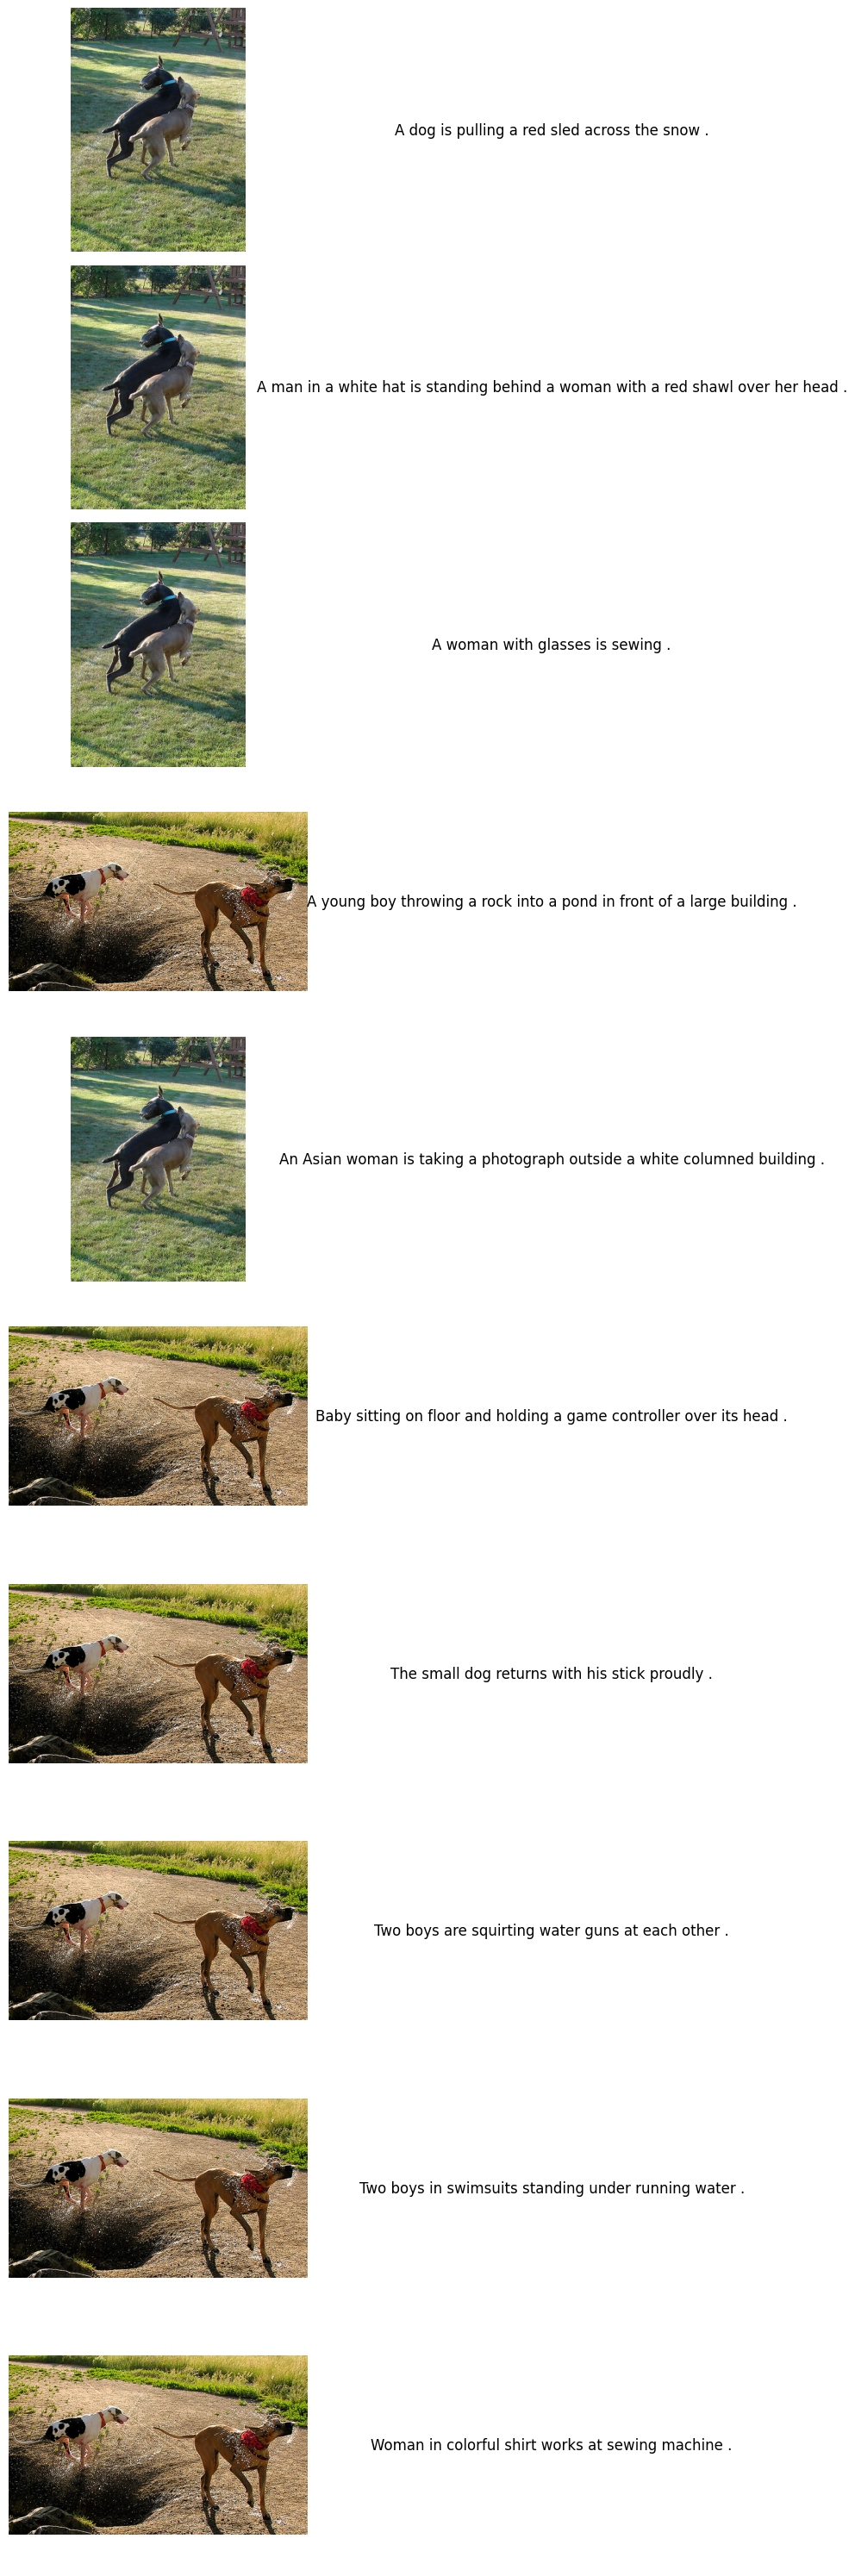

In [113]:
sample_df = result_df.head(10)
fig, axs = plt.subplots(10, 2, figsize=(10, 30))  

for i, (index, row) in enumerate(sample_df.iterrows()):
    image_path = os.path.join(path, 'test', 'test_images', row['image'])
    img = Image.open(image_path)
    
    axs[i, 0].imshow(img)
    axs[i, 0].axis('off') 
    

    axs[i, 1].text(0.5, 0.5, row['query_text'], fontsize=12, ha='center', va='center')
    axs[i, 1].axis('off')  

plt.tight_layout()
plt.show()

## Вывод

На данном эатпе модель выводит совсем не то, что нужно. Да и результат метрики низкий.

Нужна помощь. 

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска